In [299]:
'''Modified version of Cleaned_Up_Blurred_Otsu, with functions rearranged.'''

# problems:
# Thresholding on inverted images seems to produce low quality results
# not enough info from some of the images if not enough non-edge scales

'Modified version of Cleaned_Up_Blurred_Otsu, with functions rearranged.'

In [300]:
import cv2
import numpy as np
from datascience import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import sys
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 120
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import pandas
import statistics

In [301]:
def threshold_otsu(img):
    '''Parameter img should already have been read by cv2 and converted to grayscale.
    Returns sure foreground of image thresholded using Otsu.'''
    
    # Apply blur
    blur = cv2.GaussianBlur(img,(5,5),0)
    
    # Threshold image using Otsu
    ret, thresh = cv2.threshold(blur,0 , 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # Perform opening on thresholded image
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 4)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0)
    
    return sure_fg

In [302]:
def choose_blocksize_and_iterations(img):
    '''Parameter img should be the sure foreground of the Otsu-thresholded image.
    Returns selected blocksize and iterations.'''
    
    # Collect stats from image
    binary_map = (img > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    avg_scale_size = np.average(stats[1:,-1])
    
    if num_labels <= 3:
        return 15, 1
    elif avg_scale_size < 350:
        return 65, 2
    elif avg_scale_size < 550:
        return 65, 3
    else:
        return 85, 1

In [303]:
def threshold_custom(img, blocksize, iterations):
    '''Parameter img should already have been read by cv2 and converted to grayscale.'''

    if (blocksize > 15):
        blur = cv2.GaussianBlur(img,(5,5),1)
        blur = cv2.bilateralFilter(blur,10,10,100)
    else:
        blur = cv2.GaussianBlur(img,(5,5),0)

    thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blocksize, -2)

    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations=iterations)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform, 1.5, 255, 0) 

    # Collect stats from sure_foreground image
    binary_map = (sure_fg > 0).astype(np.uint8)
    connectivity = 4 # can be changed
    output = cv2.connectedComponentsWithStats(binary_map, connectivity, cv2.CV_32S)
   
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    
    scale_sizes = np.copy(stats[1:,-1]) # start from 1 instead of 0 to ignore background, use copy so that stats array doesn't get modified
    scale_sizes.sort() # sort the list of scale sizes from smallest to largest
    avg_scale_size = np.average(scale_sizes[len(scale_sizes) // 2:]) # average size among the largest half of the scales
    
    # Identifying noise
    noise_labels = []
    for i in range(num_labels):
        # if the scale is smaller than 1/10 the average among the largest half of the scales, save it for removal
        if stats[i, -1] < (avg_scale_size / 10):
            noise_labels.append(i)
            num_labels -= 1
    # Remove the identified noise
    for i in range(len(labels)):
        for j in range(len(labels[i])):
            if labels[i][j] in noise_labels:
                labels[i][j] = 0 # turn noise pixels into background pixels
    # Note: Removed noise from labels matrix, but the noise is still in stats/centroids matrices
    
    # Label and count
    # source: https://medium.com/analytics-vidhya/images-processing-segmentation-and-objects-counting-in-an-image-with-python-and-opencv-216cd38aca8e
    label_hue = np.uint8(179 * labels / np.max(labels))
    blank_ch = 255 * np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)
    labeled_img[label_hue == 0] = 0
    
    return sure_fg, labeled_img, num_labels - 1 # background doesn't count as a scale

In [304]:
def display_results_orig(orig, with_noise, noise_removed, count):
    plt.subplot(1,3,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.subplot(1,3,2), plt.imshow(with_noise, 'gray')
    plt.title("With Noise", fontsize=5)
    plt.subplot(1,3,3), plt.imshow(noise_removed, 'gray')
    plt.title("Noise-Removed, Count = " + str(count), fontsize=5)
    plt.show()

def display_results_invert(orig, invert, with_noise, noise_removed, count):
    plt.subplot(1,4,1), plt.imshow(orig, 'gray')
    plt.title("Orginal Grayscale", fontsize=5)
    plt.subplot(1,4,2), plt.imshow(invert, 'gray')
    plt.title("Inverted", fontsize=5)
    plt.subplot(1,4,3), plt.imshow(with_noise, 'gray')
    plt.title("Inverted With Noise", fontsize=5)
    plt.subplot(1,4,4), plt.imshow(noise_removed, 'gray')
    plt.title("Inverted Noise-Removed, Count = " + str(count), fontsize=5)
    plt.show()

In [305]:
#All of these ranges are completely arbitrary at this point and will be determined through experimentation
small = range(0, 5)
medium = range(5, 10)
large = range(10, 100)
small_expected_count = range(30, 101)
med_expected_count = range(10, 30)
large_expected_count = range(0, 10)


def analyze_results(img, scale_size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    binary_map = (img > 0).astype(np.uint8) # make the labeled image binary (make everything that is not black be white)
    output = cv2.connectedComponentsWithStats(binary_map, 4, cv2.CV_32S)
    num_labels = output[0]
    labels = output[1]
    stats = output[2]
    centroids = output[3]
    size_var = scale_size_variation(num_labels, stats, len(img), len(img[0]))
    overlap = overlap_of_bounds(num_labels, stats, len(img), len(img[0])) #bounding box overlap not that useful - maybe only use to eliminate if extremely high, like > 1?
    fullness, squareness = fullness_and_squareness(num_labels, stats, len(img), len(img[0]))
    comp_exp = compare_to_expected(num_labels, scale_size)
    
    return size_var, overlap, fullness, squareness, comp_exp
        
    
    
###Returns True if the actual count is within the expected range given scale area, else False.
def compare_to_expected(num_labels, scale_size):
    if scale_size == small:
        if num_labels in small_expected_count:
            return True
    elif scale_size == medium:
        if num_labels in med_expected_count:
            return True
    elif scale_size == large:
        if num_labels in large_expected_count:
            return True
    else:
        return False
        
        
        
def bounding_box_edges(i, stats):
     # find edges of bounding box
        left = stats[i, cv2.CC_STAT_LEFT]
        right = left + stats[i, cv2.CC_STAT_WIDTH] - 1
        top = stats[i, cv2.CC_STAT_TOP]
        bottom = top + stats[i, cv2.CC_STAT_HEIGHT] - 1
        return left, right, top, bottom
        
def scale_size_variation(num_labels, stats, img_len, img_width):
    scale_areas = []
    for i in range(1, num_labels): # start at 1 to ignore background
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        scale_areas.append(stats[i, cv2.CC_STAT_AREA].astype(int))

    if len(scale_areas) > 1:
        stddev = statistics.stdev(scale_areas)
        mean = sum(scale_areas) / len(scale_areas)
        #print("(Std dev / mean) for scale area: " + str(stddev / mean))
       
        # thresholding good if return value less than 1
        return (stddev / mean)
        # returns None if less than 2 non-edge scales
        
def overlap_of_bounds(num_labels, stats, img_len, img_width):
    if num_labels < 2: # return None if no scales
        return
    #check for overlappingness of bounding boxes
    overlap_array = np.zeros((img_len, img_width))
    for i in range(1, num_labels): # start at 1 to ignore background
        left, right, top, bottom = bounding_box_edges(i, stats)
        for r in range(top, bottom + 1):
            for c in range(left, right + 1):
                overlap_array[r, c] += 1
    avg_overlap = np.average(overlap_array)
    #print("Avg bounding box overlap: " + str(avg_overlap))
    percent_overlap = np.count_nonzero(overlap_array > 1) / np.size(overlap_array)
    
    # thresholding good if return value less than 0.63
    return avg_overlap
    
def fullness_and_squareness(num_labels, stats, img_len, img_width):
    
    squareness = []
    fullness = []
    for i in range(1, num_labels):
        
        left, right, top, bottom = bounding_box_edges(i, stats)
        # don't consider scales that touch the edge
        if left == 0 or top == 0 or right == img_width - 1 or bottom == img_len - 1:
            continue
            
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        squareness.append(min(w, h) / max(w, h)) # closer to 1 means more square, smaller than 1 means less square
        
        scale_area = stats[i, cv2.CC_STAT_AREA]
        box_area = w * h
        fullness.append(scale_area / box_area)
    if fullness:
        avg_fullness = sum(fullness) / len(fullness)
        #print("Avg fullness: " + str(avg_fullness))
        squareness.sort()
        least_square = squareness[:10]
        avg_squareness = sum(least_square) / len(least_square)
        #print("Avg squareness of 10 least square scales: " + str(avg_squareness))
    
        # thresholding good if return value > 0.7
        return avg_fullness, avg_squareness
    else:
        return None, None
    # returns None if no non-edge scales

In [306]:
def compare_results(result_list):
    '''Compares the data from different thresholding attempts and returns the index corresponding to the best.
    Each element in parameter result_list is a list of the form [size_var, overlap, fullness, squareness, comp_exp]
    resulting from analysis of a thresholding attempt.'''
    orig_data = result_list[0]
    inverted_data = result_list[1]
    
    size_var = [orig_data[0], inverted_data[0]]
    overlap = [orig_data[1], inverted_data[1]]
    fullness = [orig_data[2], inverted_data[2]]
    squareness = [orig_data[3], inverted_data[3]]
    comp_exp = [orig_data[4], inverted_data[4]]
    
    orig, inverted = 0, 0
    
    #adjust the weights? - currently larger differences count more, but all 4 criteria (size_var, overlap, etc.) are weighted equally
    # Maybe size variation should have greatest weight?
    # Compare size variation
    if size_var[0] and size_var[1]:
        if size_var[0] < size_var[1]:
            orig += size_var[1] - size_var[0]
        elif size_var[0] > size_var[1]:
            inverted += size_var[0] - size_var[1]
    else: # if one or more the results don't have data on size variation (b/c less than 2 non-edge scales)
        return 0 # scale size variation is very important, so we can't make conclusions - when in doubt, keep original image
    
    # Compare overlap of bounding boxes
    if overlap[0] and overlap[1]:
        if overlap[0] < overlap[1]:
            orig += overlap[1] - overlap[0]
        if overlap[0] > overlap[1]:
            inverted += overlap[0] - overlap[1]
        
    # Compare fullness (scale to bounding box ratio)
    if fullness[0] and fullness[1]:
        if fullness[0] > fullness[1]:
            orig += fullness[0] - fullness[1]
        elif fullness[0] < fullness[1]:
            inverted += fullness[1] - fullness[0]
    
    # Compare squareness of bounding boxes
    if squareness[0] and squareness[1]:
        if squareness[0] > squareness[1]:
            orig += squareness[0] - squareness[1]
        elif squareness[0] < squareness[1]:
            inverted += fullness[1] - fullness[0]
    
    # Compare actual count to expected count
    if comp_exp[0] == True and comp_exp[1] == False:
        orig += 1
    elif comp_exp[0] == False and comp_exp[1] == True:
        inverted += 1
    
    # Return the index corresponding to the better result
    if orig > inverted:
        return 0
    else:
        return 1


In [307]:
def invert(img):
    return cv2.bitwise_not(img)

In [308]:
def count_scales(img):
    '''Parameter img must already have been read into cv2 and converted to grayscale.
    Calls threshold_otsu, then choose_blocksize_and_iterations, then threshold_custom.
    Returns resulting images and count.'''
    img_otsu = threshold_otsu(img)
    blocksize, iterations = choose_blocksize_and_iterations(img_otsu)
    print("Blocksize, iterations: " + str(blocksize) + ", " + str(iterations))
    with_noise, labeled_img, count = threshold_custom(img, blocksize, iterations)
    return with_noise, labeled_img, count

Blocksize, iterations: 65, 2
Finished on first try.


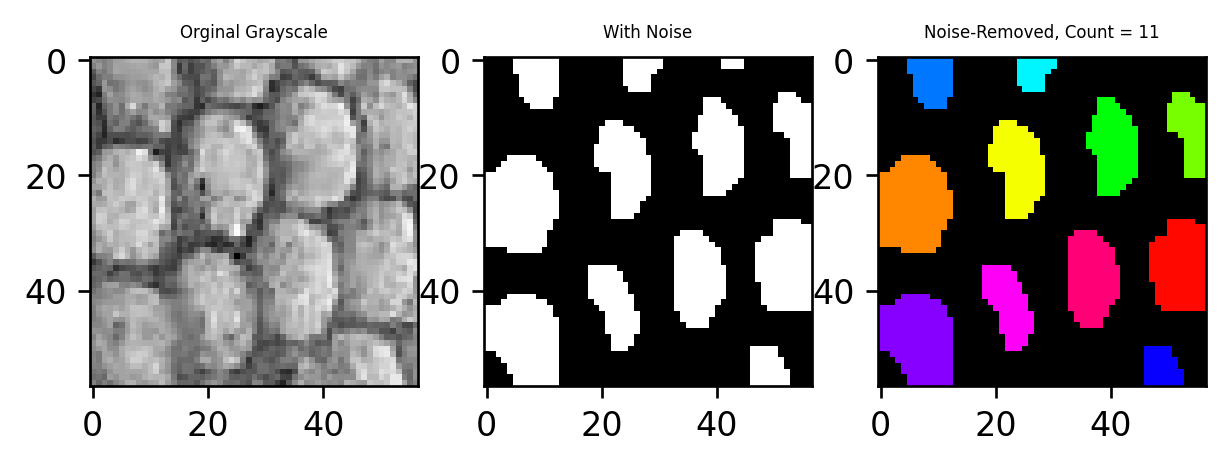

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


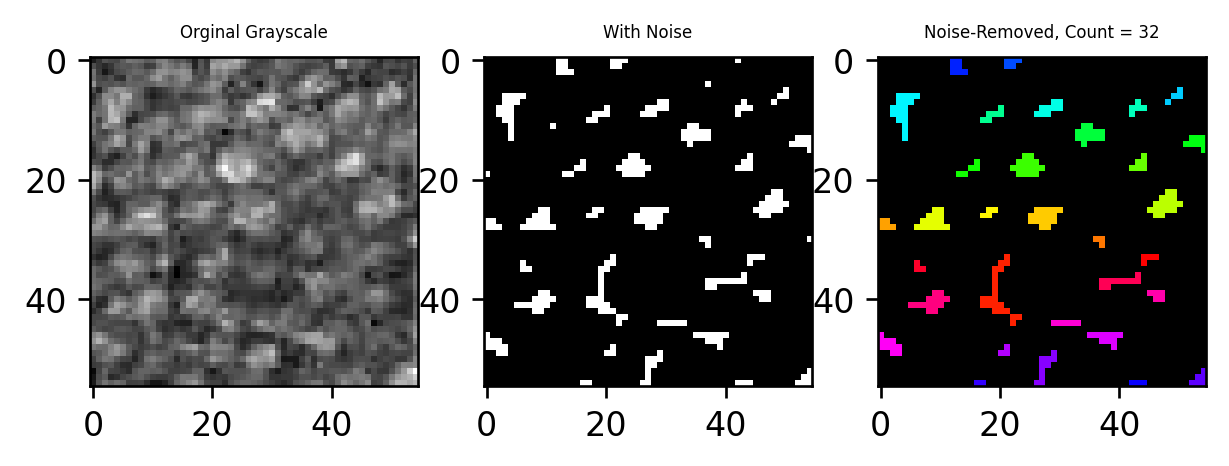

Blocksize, iterations: 85, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


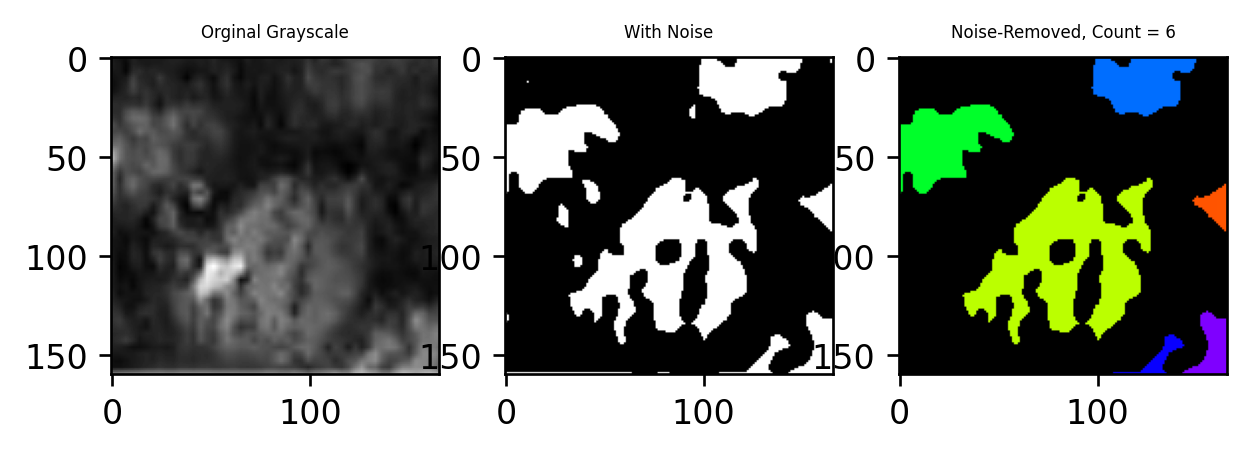

Blocksize, iterations: 85, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


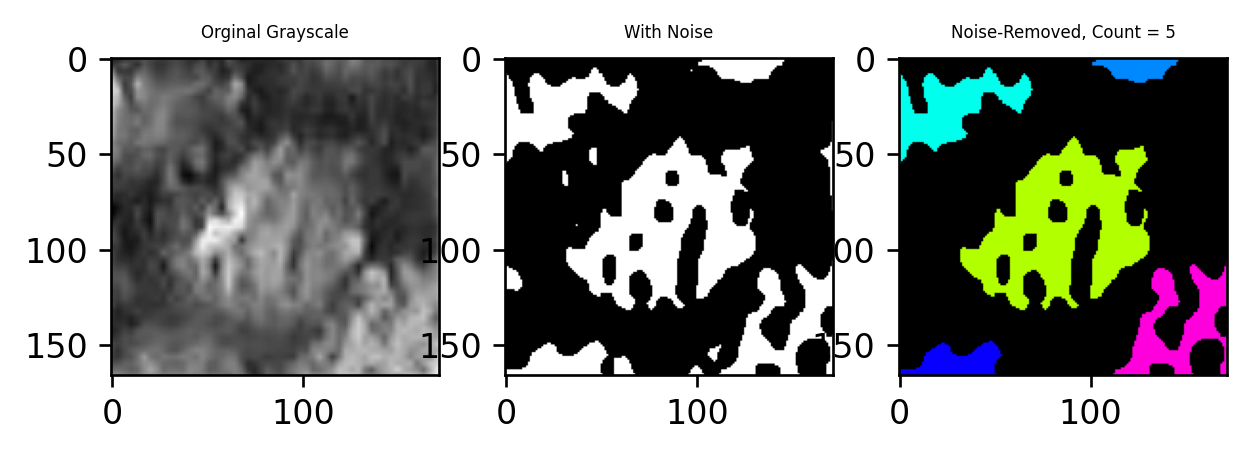

Blocksize, iterations: 15, 1
Finished on first try.


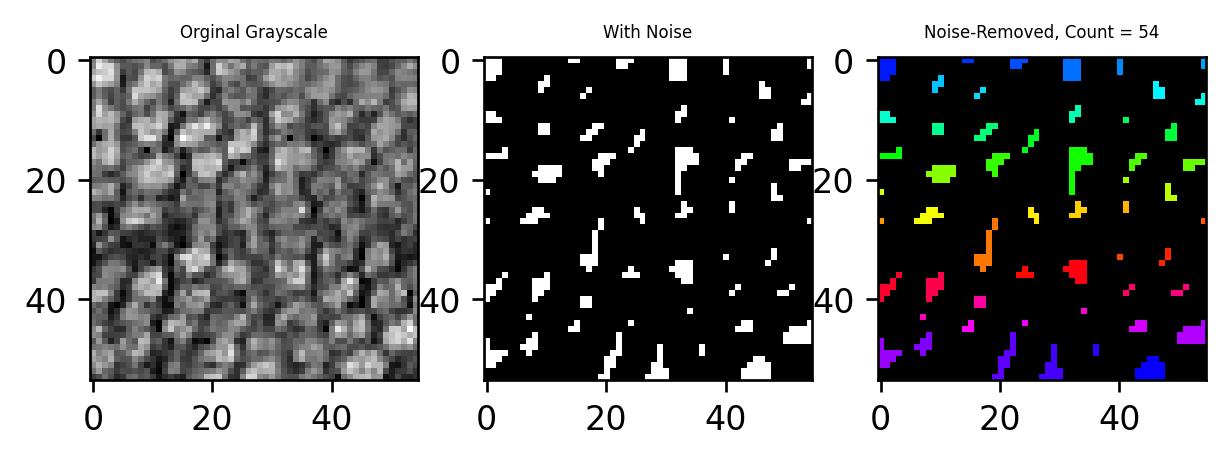

Blocksize, iterations: 15, 1
Finished on first try.


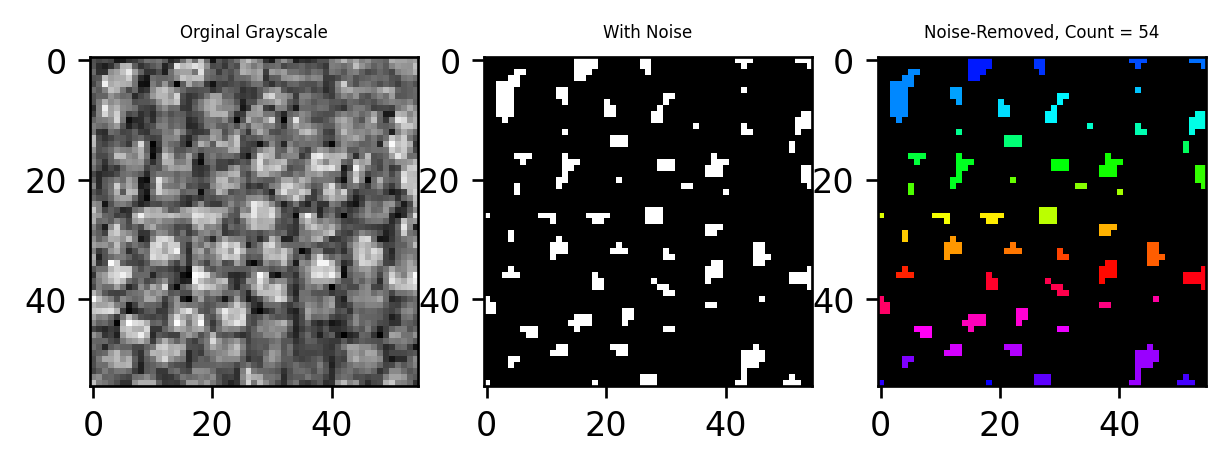

Blocksize, iterations: 15, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


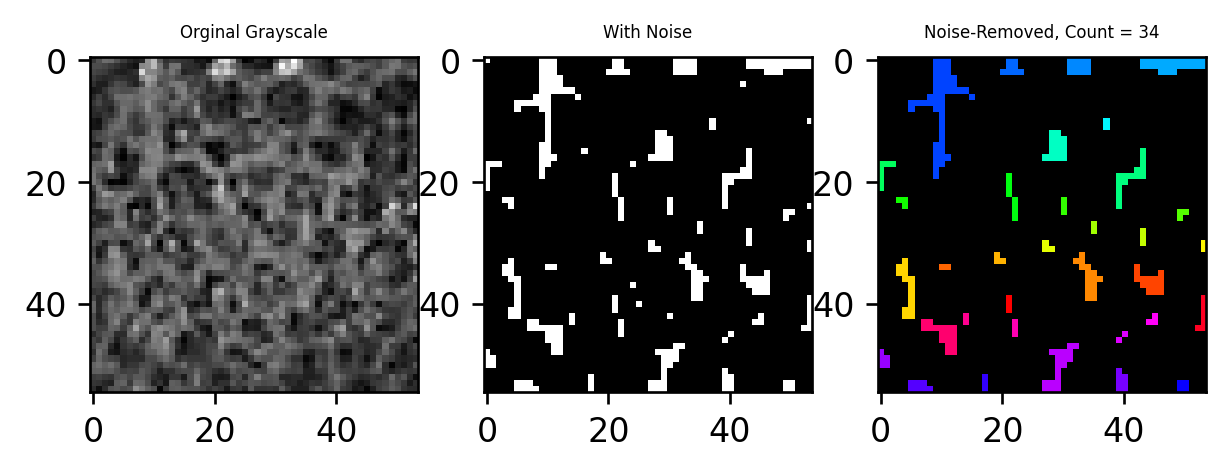

Blocksize, iterations: 85, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


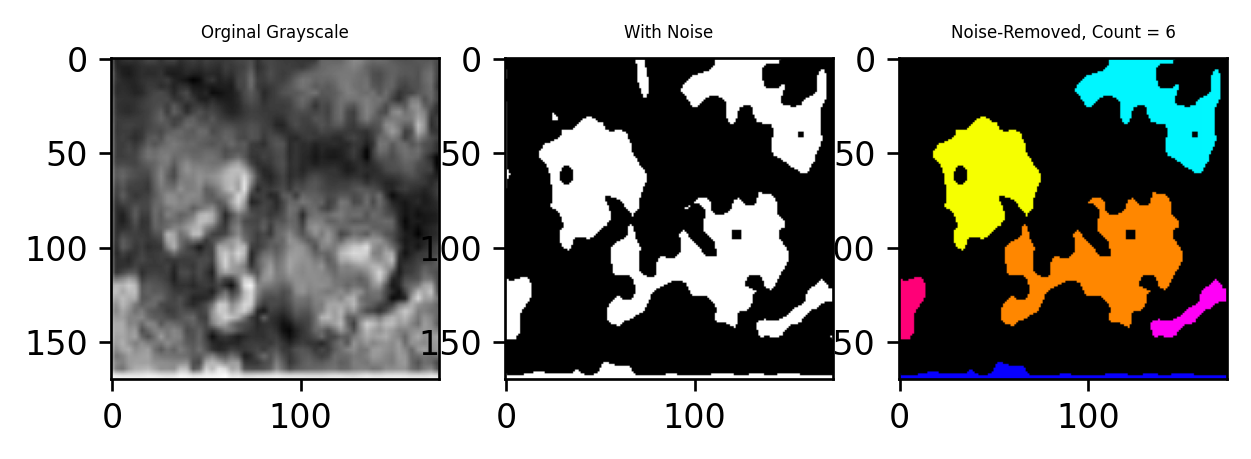

Blocksize, iterations: 85, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


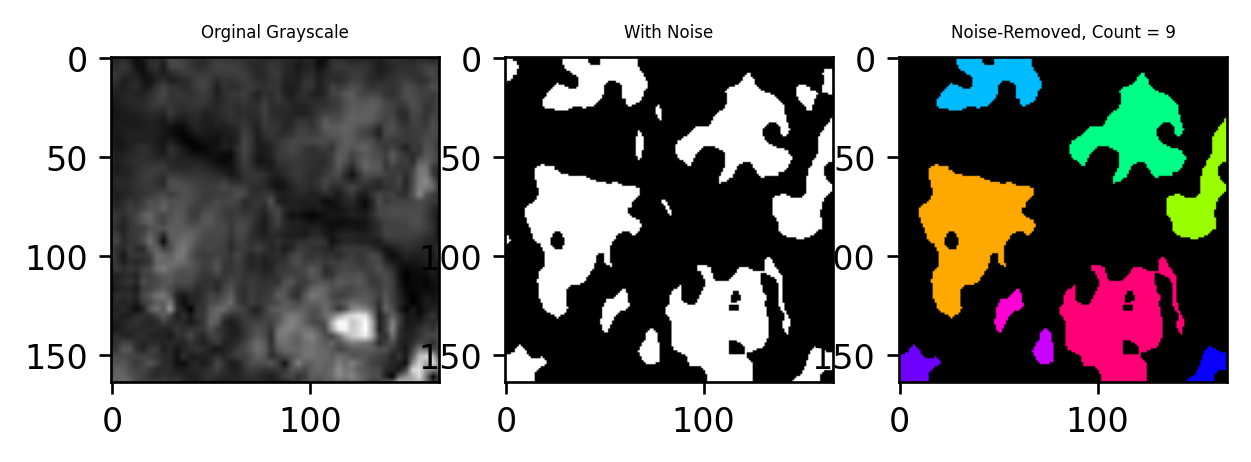

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


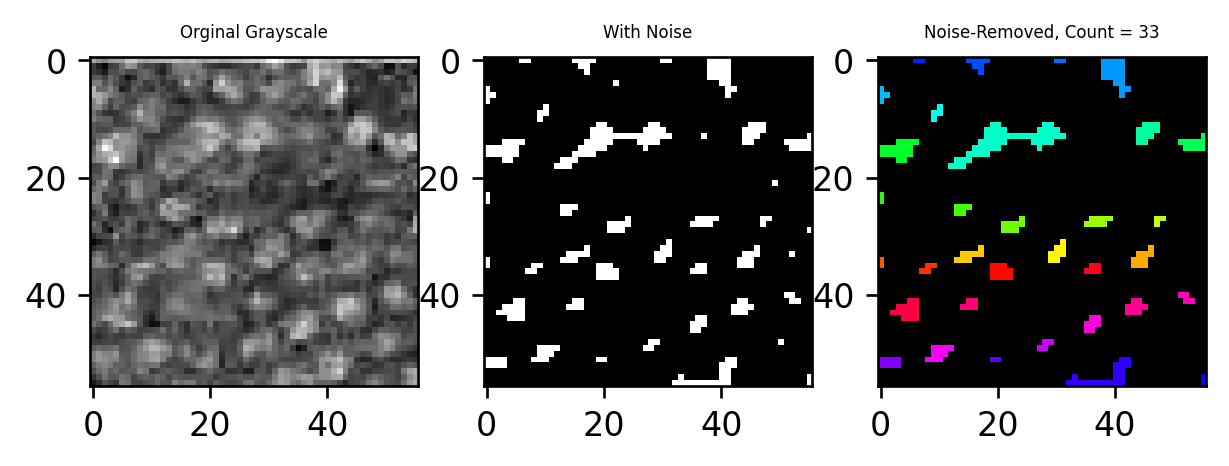

Blocksize, iterations: 65, 2
Finished on first try.


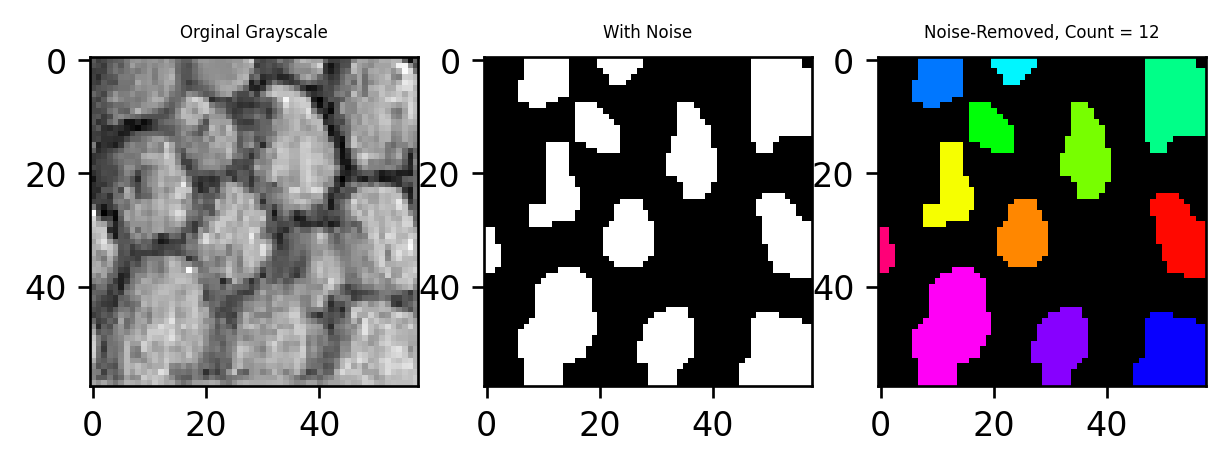

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Decided to used inverted image.


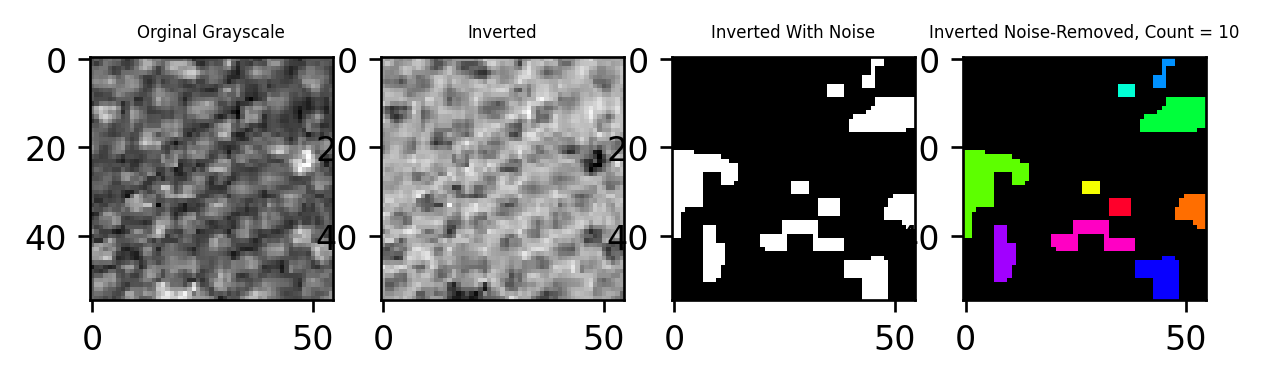

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


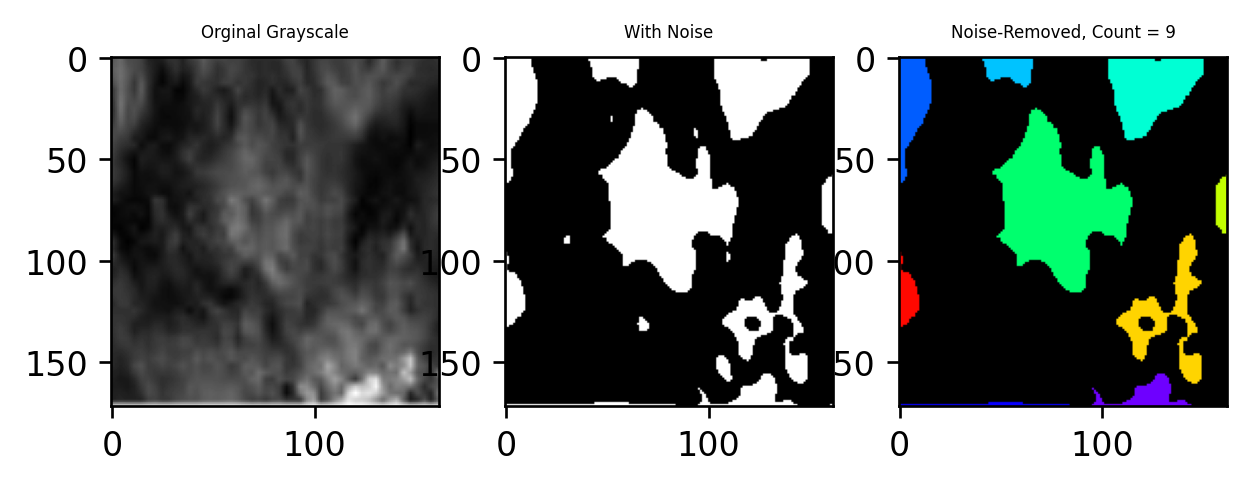

Blocksize, iterations: 15, 1
Blocksize, iterations: 15, 1
Decided to used inverted image.


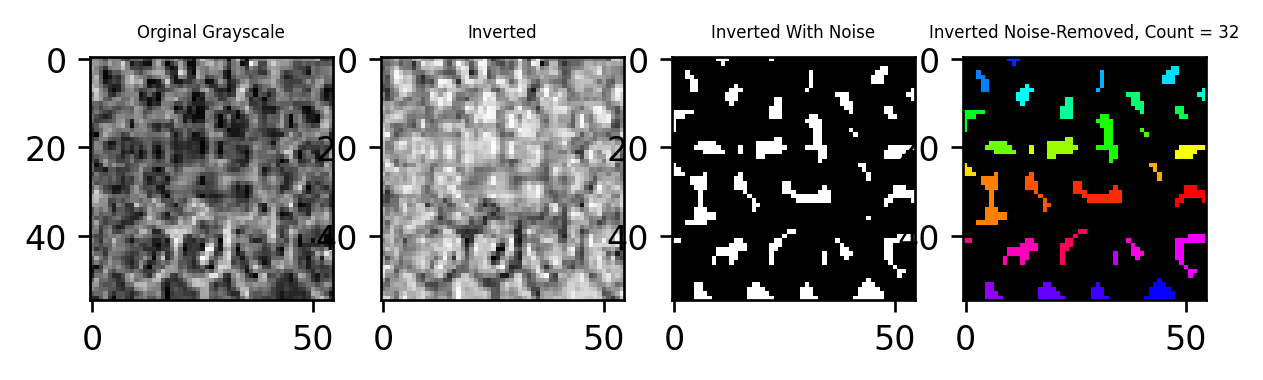

Blocksize, iterations: 15, 1
Finished on first try.


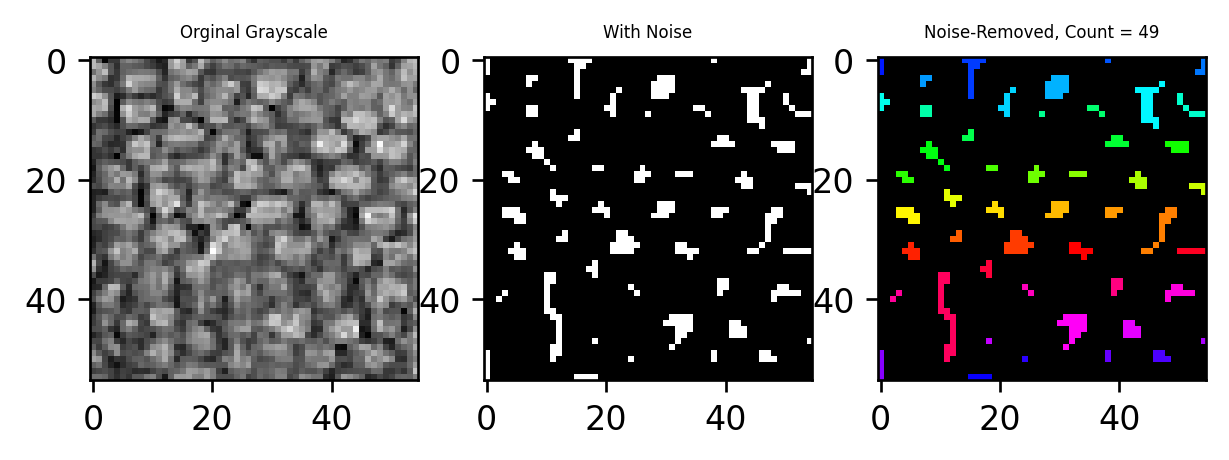

Blocksize, iterations: 15, 1
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


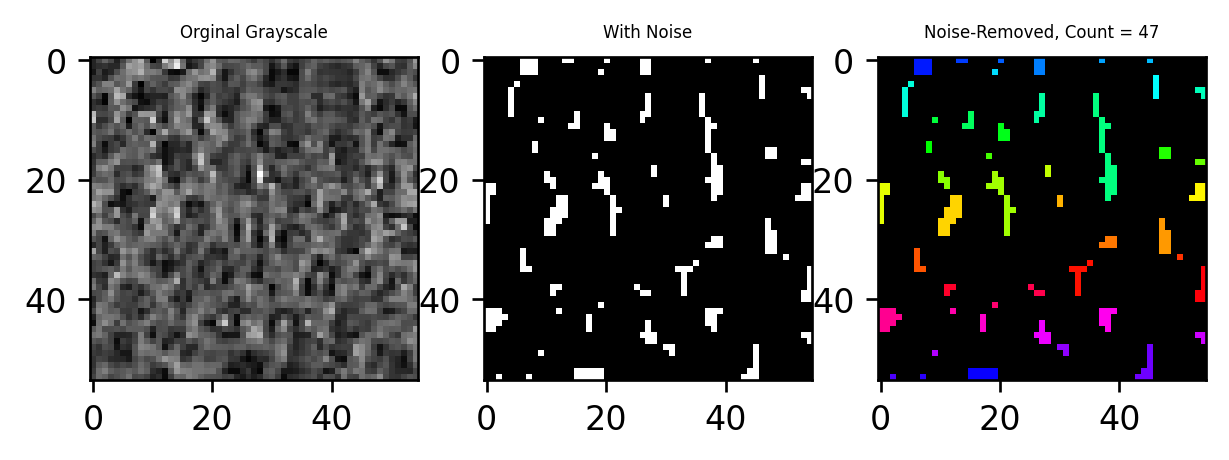

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


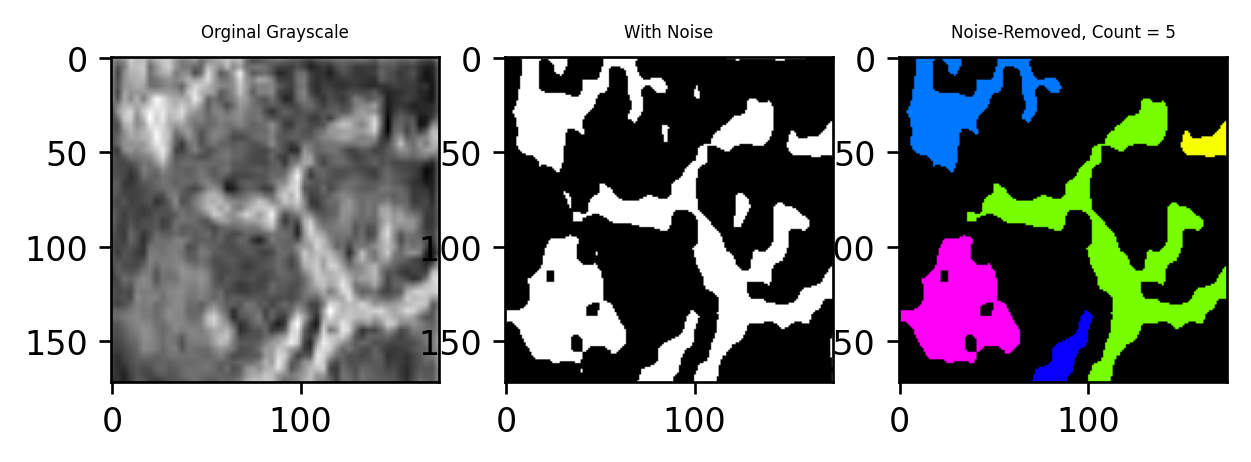

Blocksize, iterations: 65, 2
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


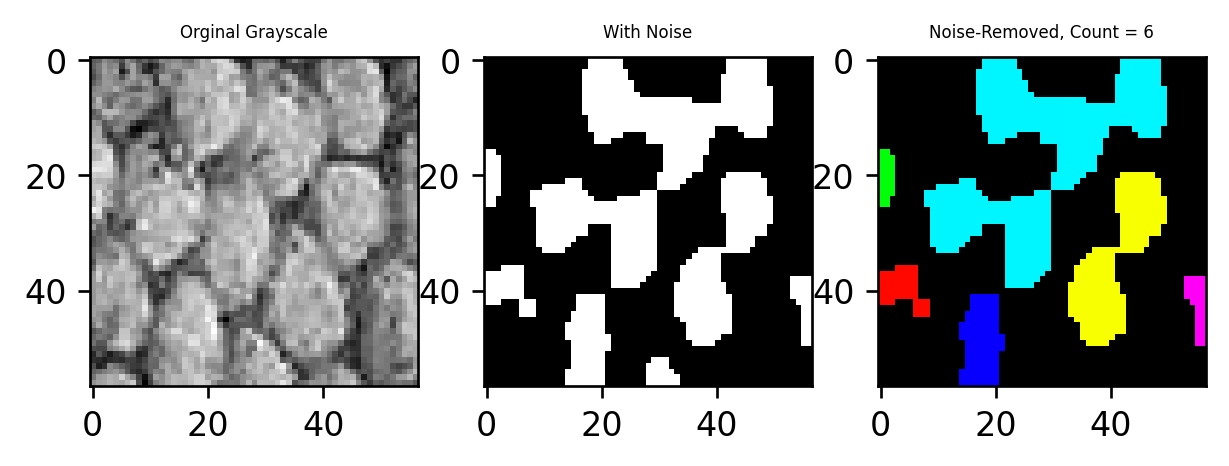

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


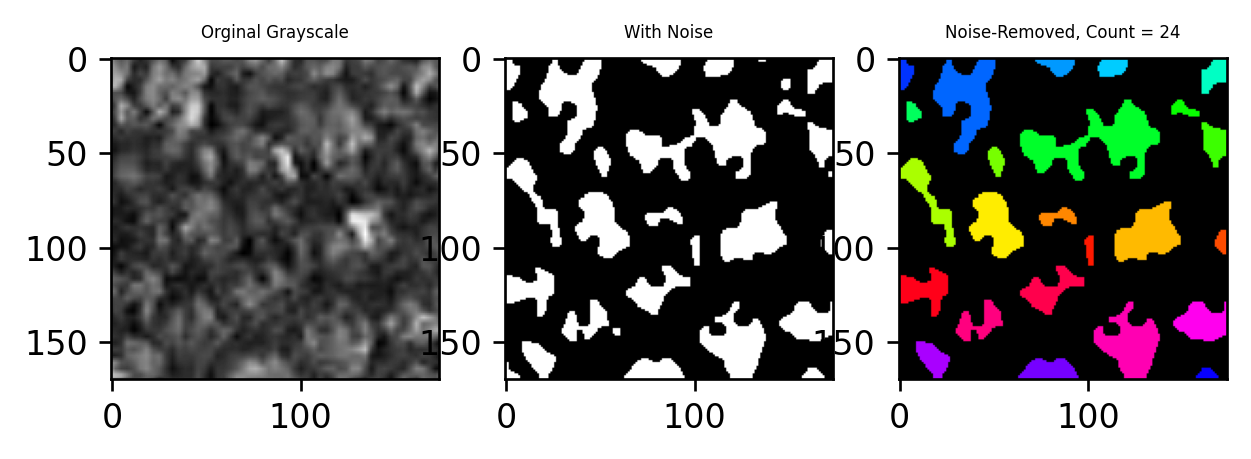

Blocksize, iterations: 65, 3
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


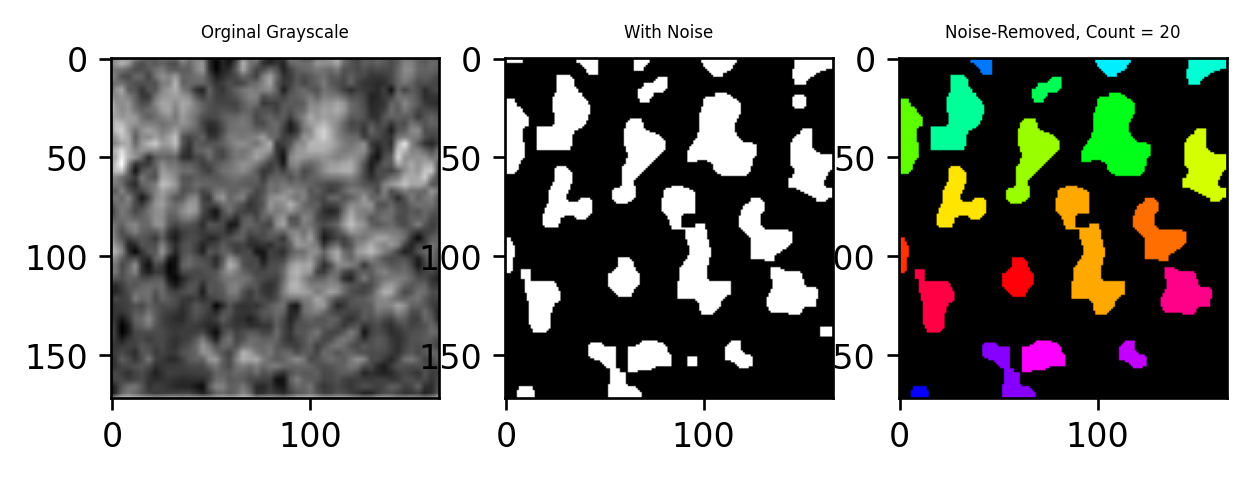

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


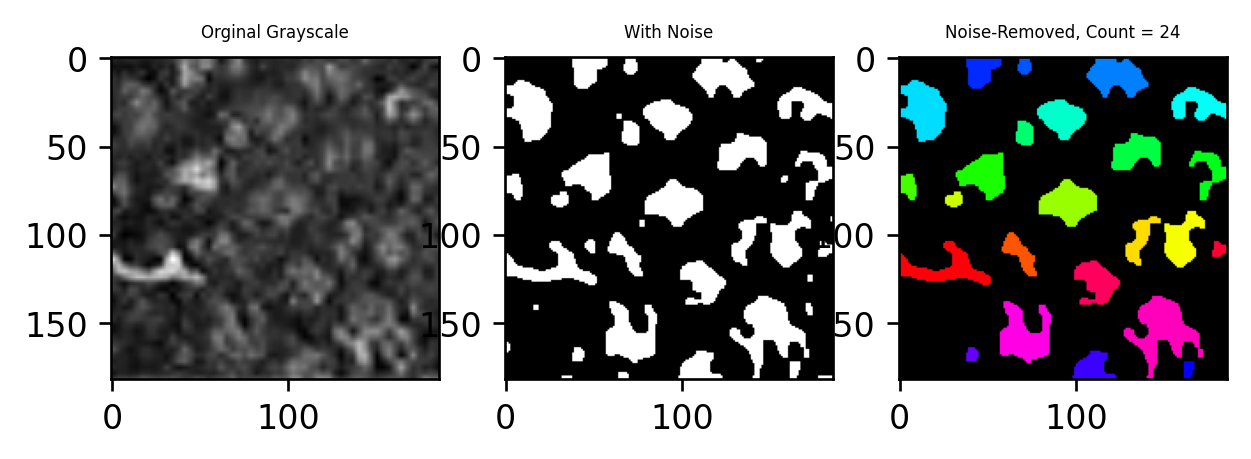

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


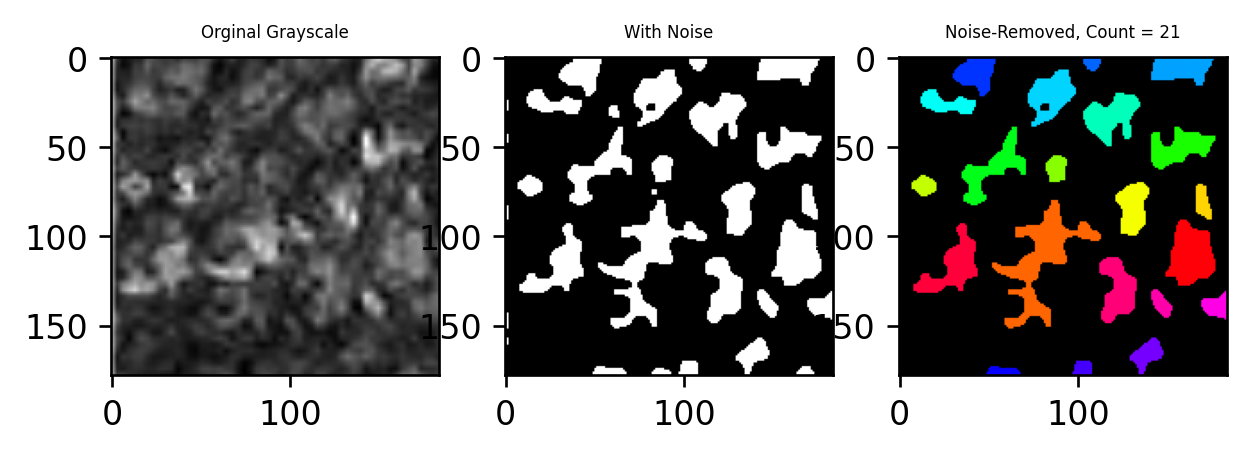

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


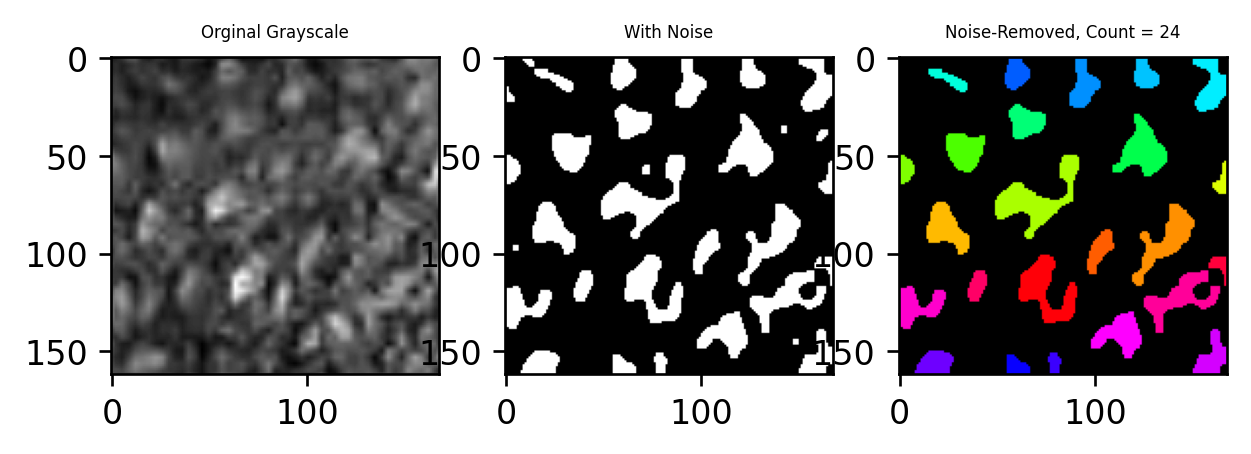

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


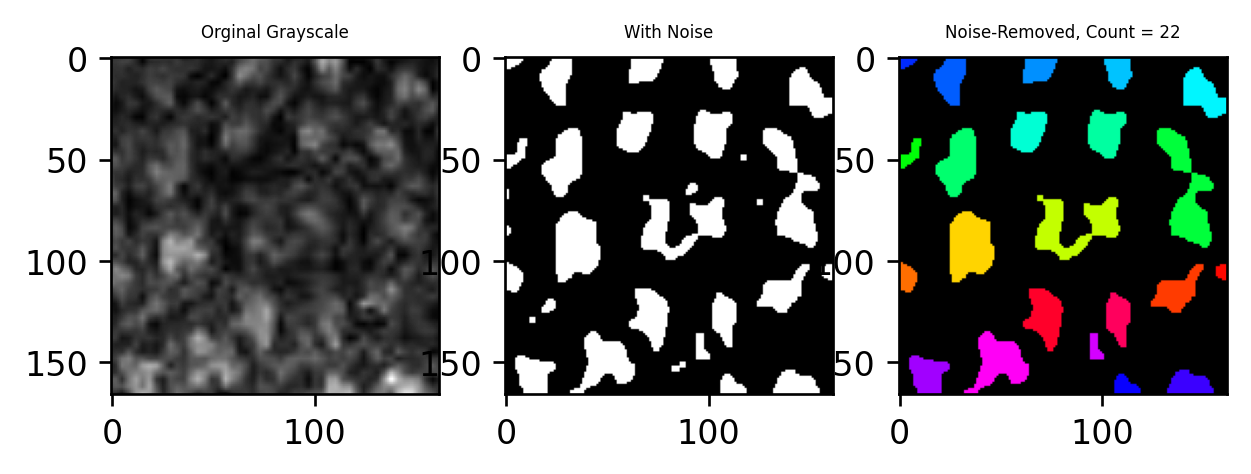

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


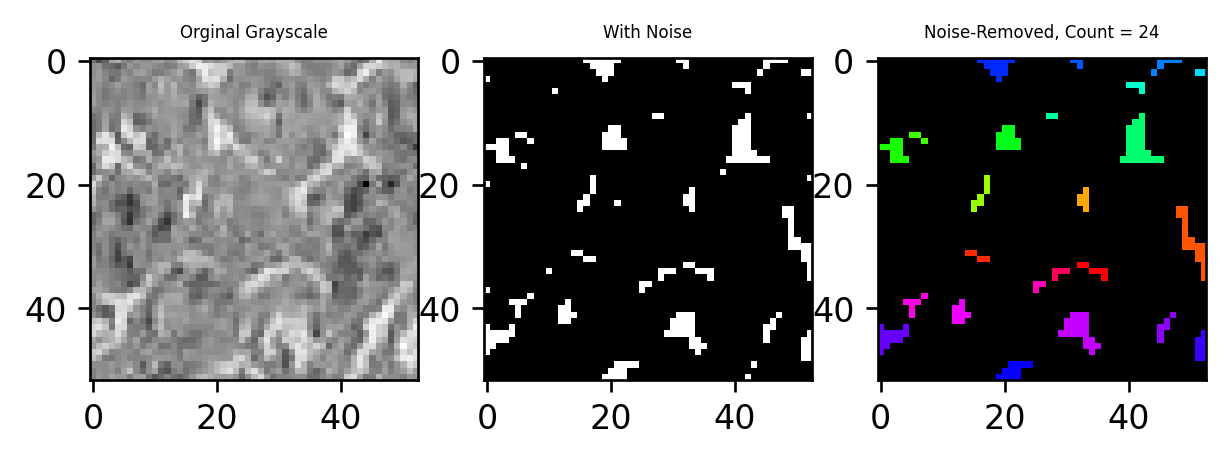

Blocksize, iterations: 65, 2
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


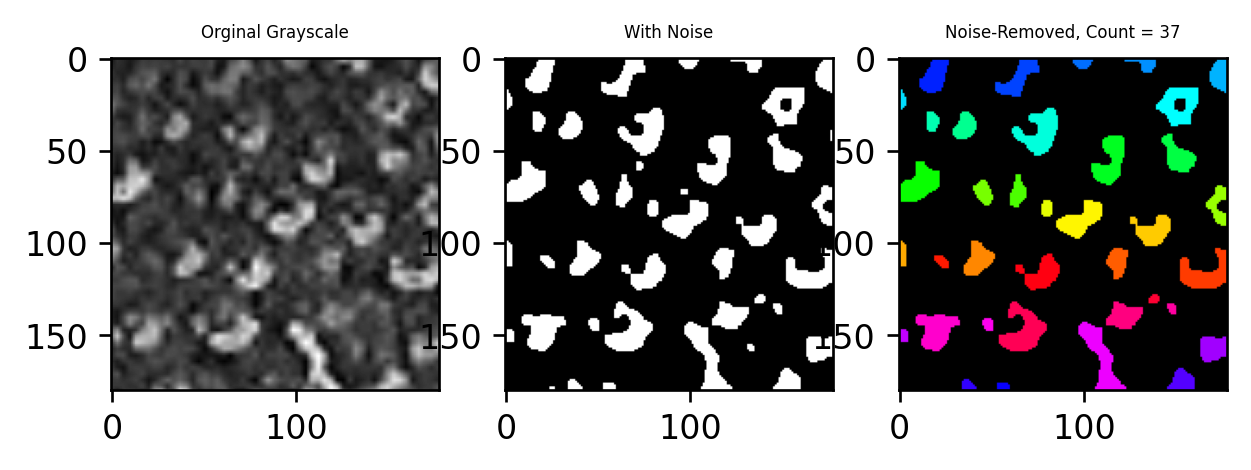

Blocksize, iterations: 65, 2
Finished on first try.


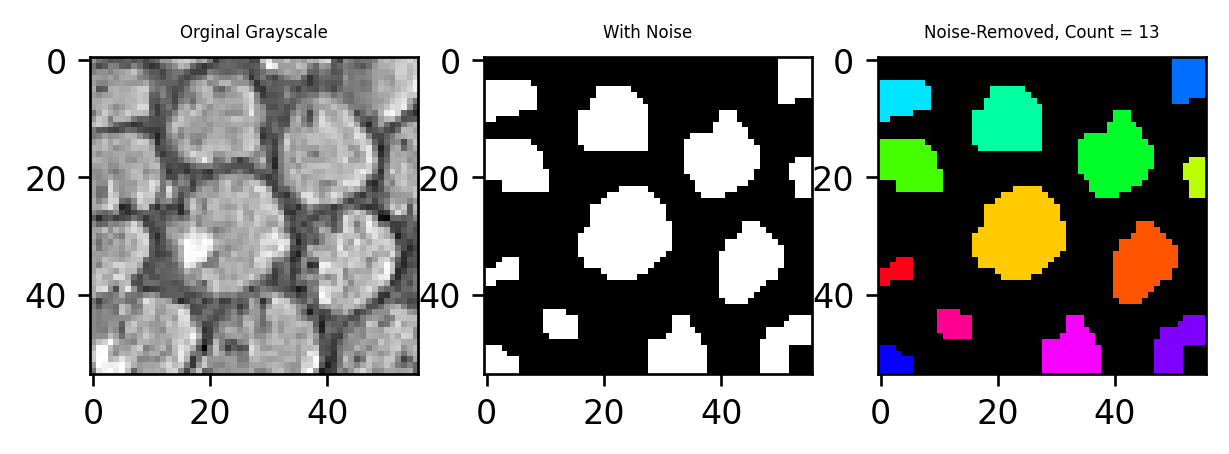

Blocksize, iterations: 65, 2
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


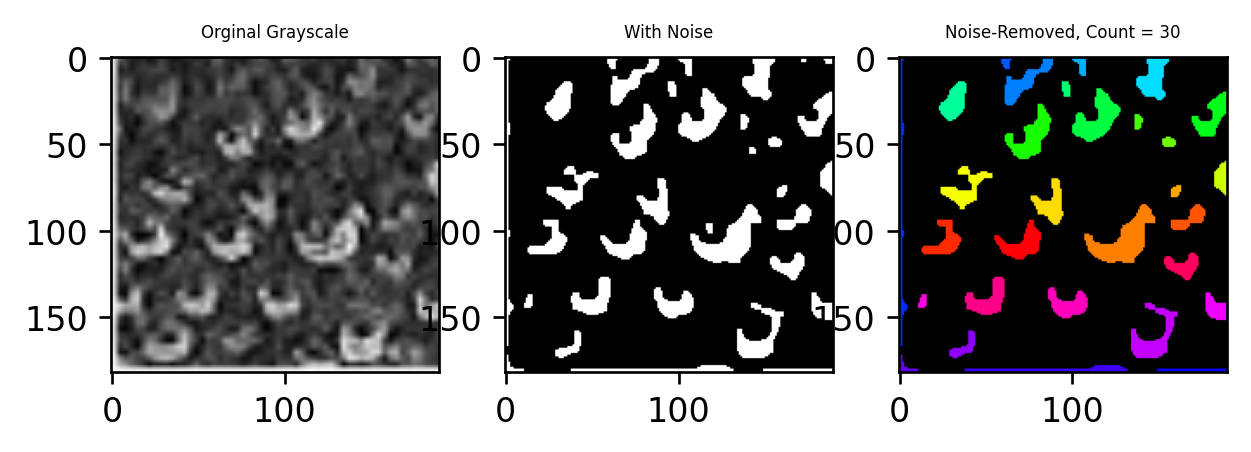

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


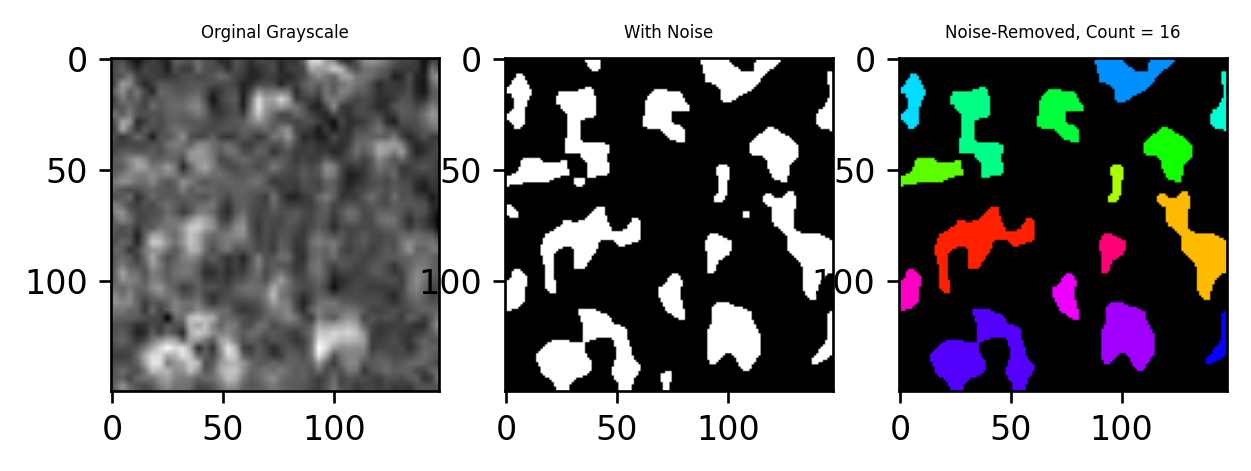

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


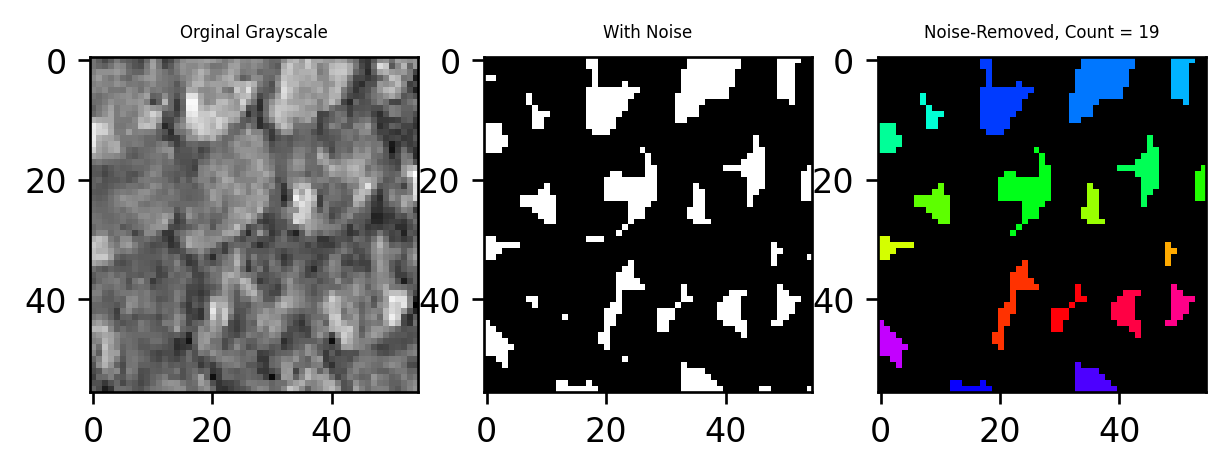

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


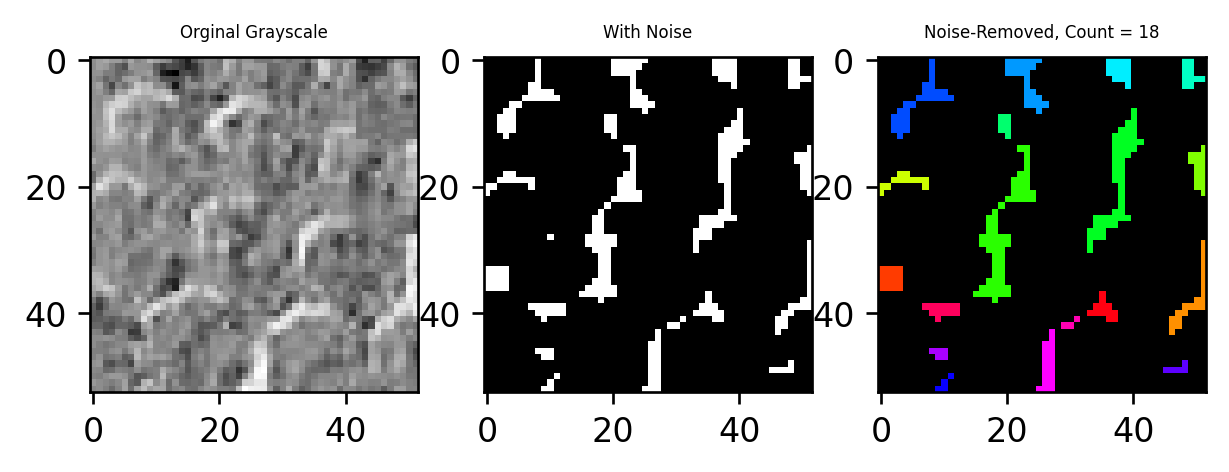

Blocksize, iterations: 65, 2
Finished on first try.


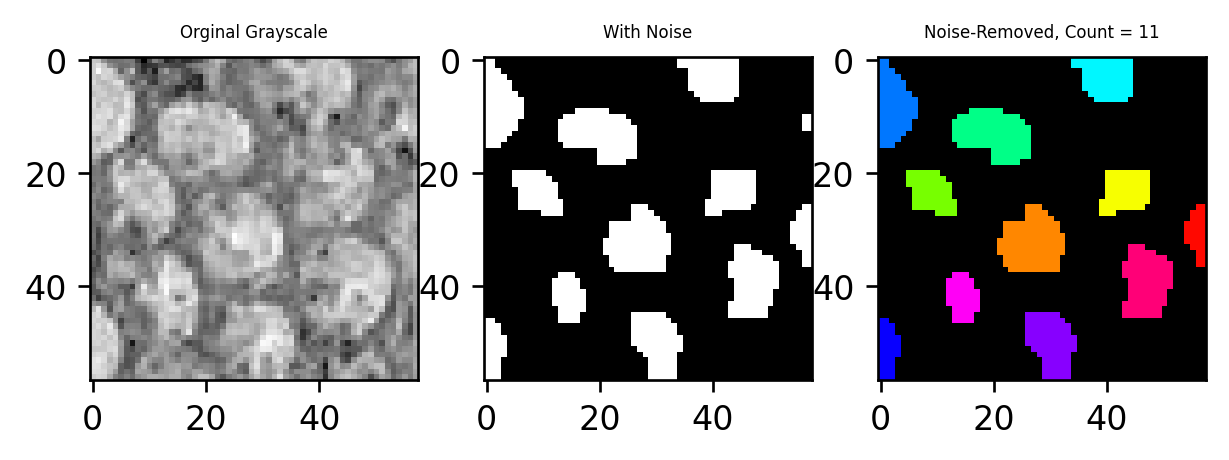

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


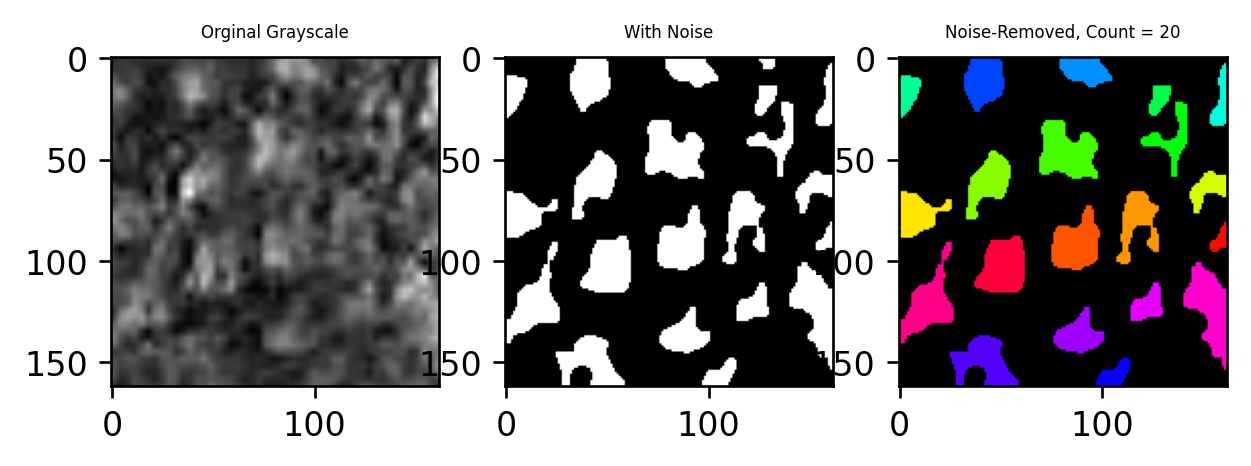

Blocksize, iterations: 65, 3
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


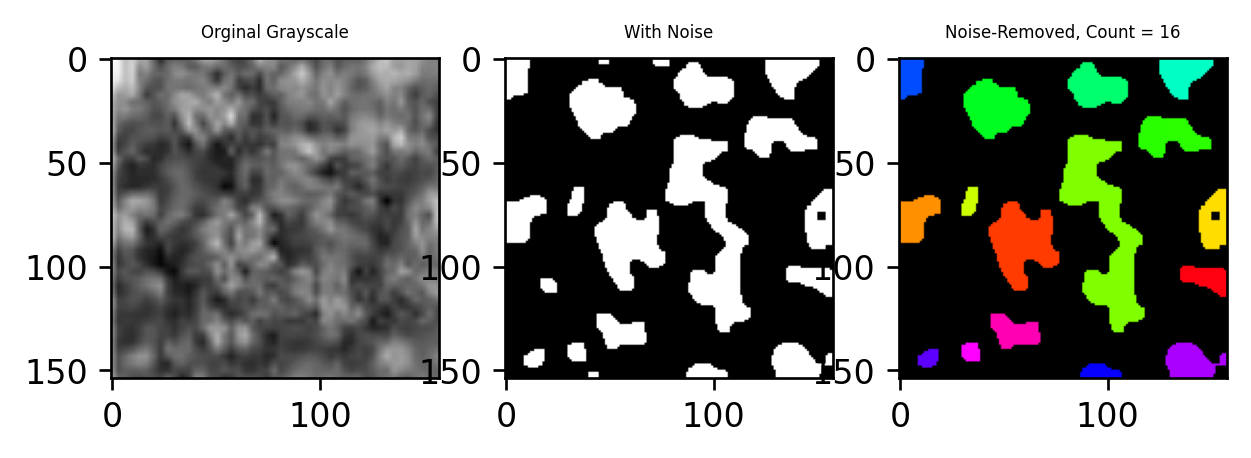

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


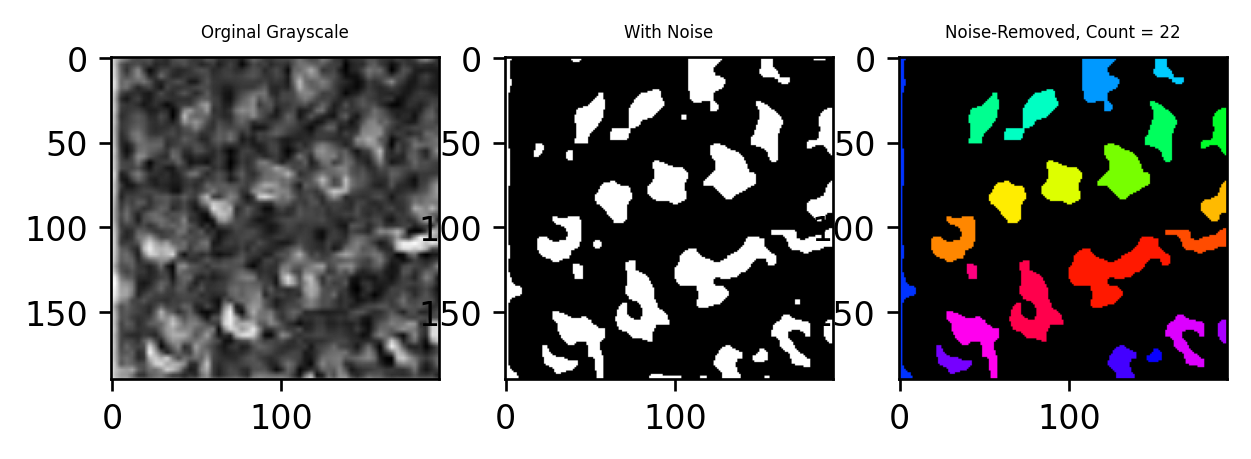

Blocksize, iterations: 65, 2
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


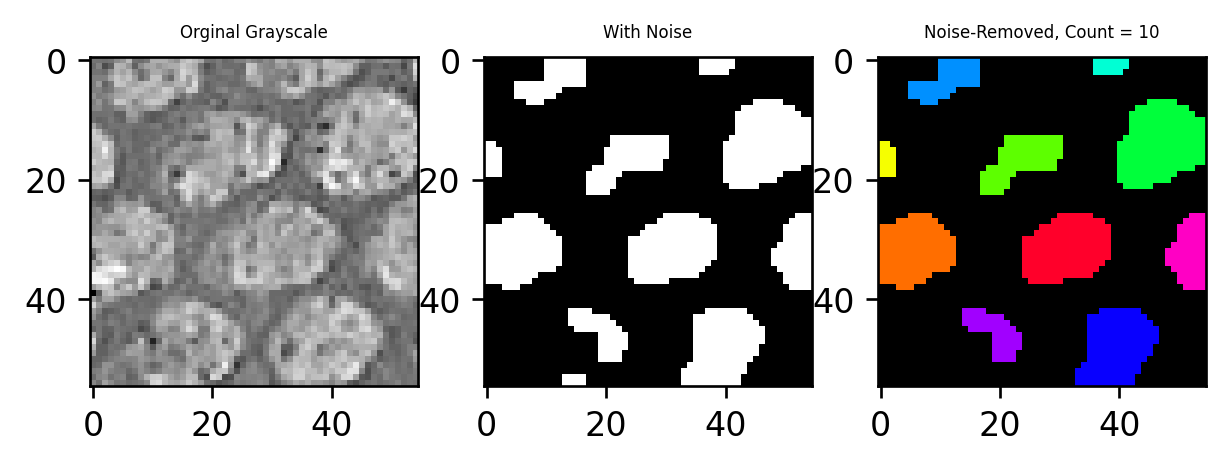

Blocksize, iterations: 65, 2
Finished on first try.


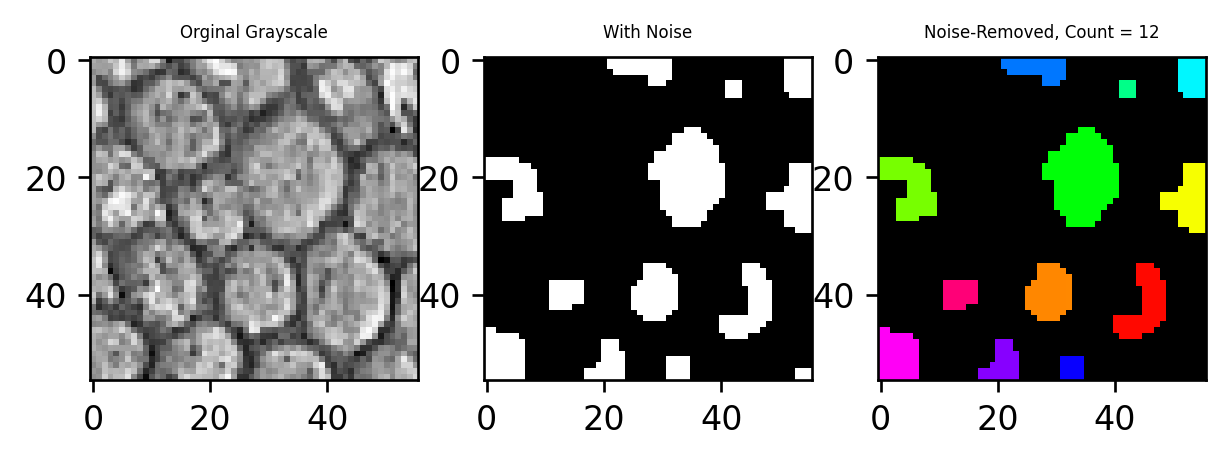

Blocksize, iterations: 65, 2
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


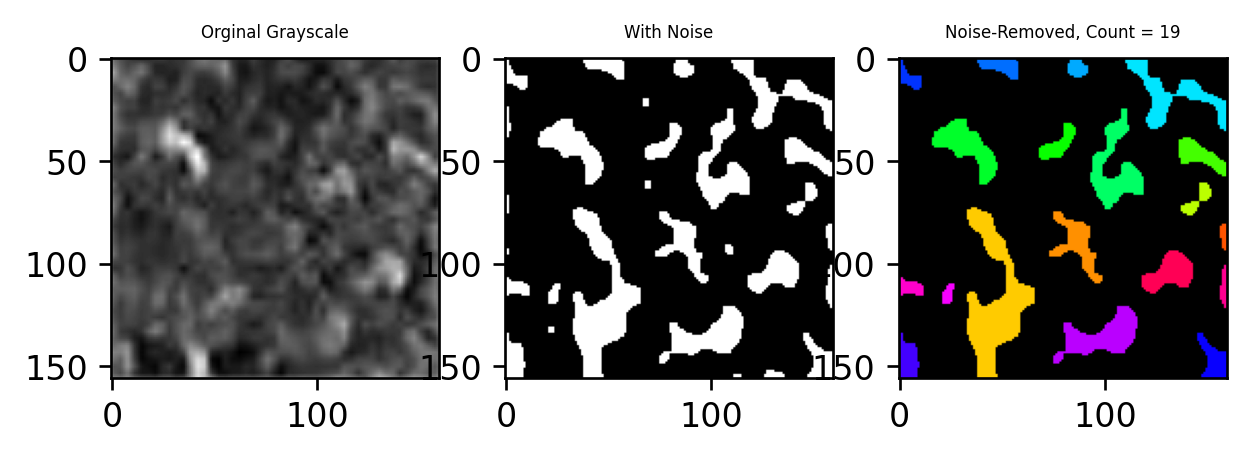

Blocksize, iterations: 65, 2
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


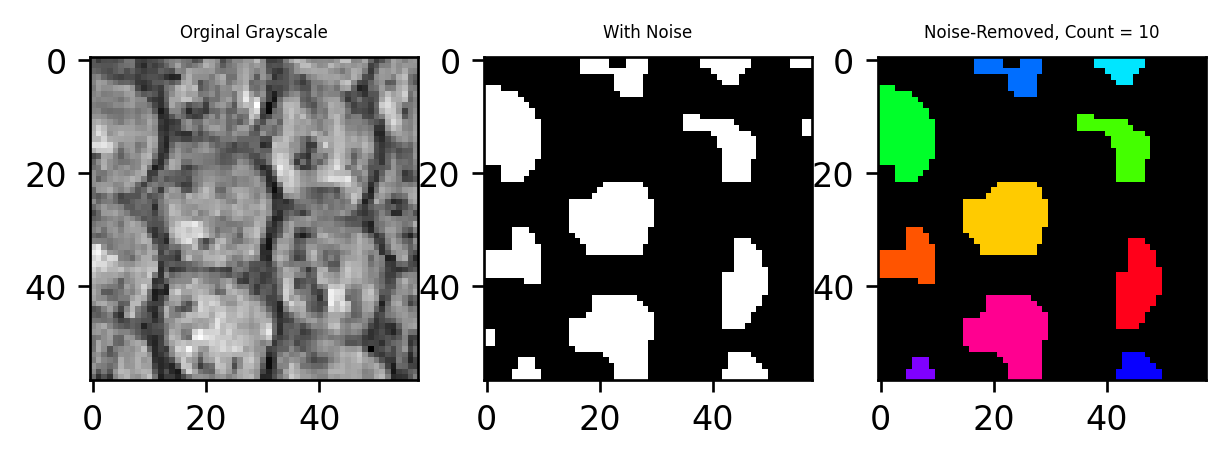

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Decided to used inverted image.


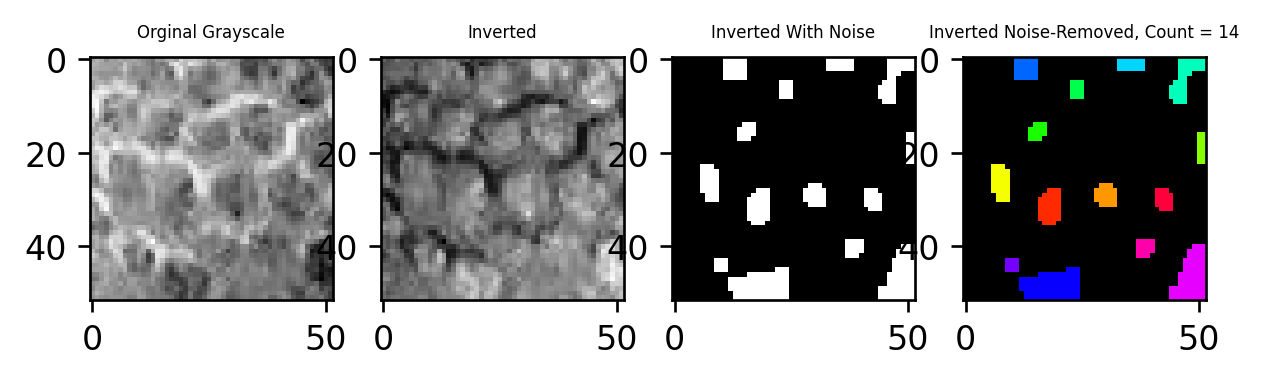

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


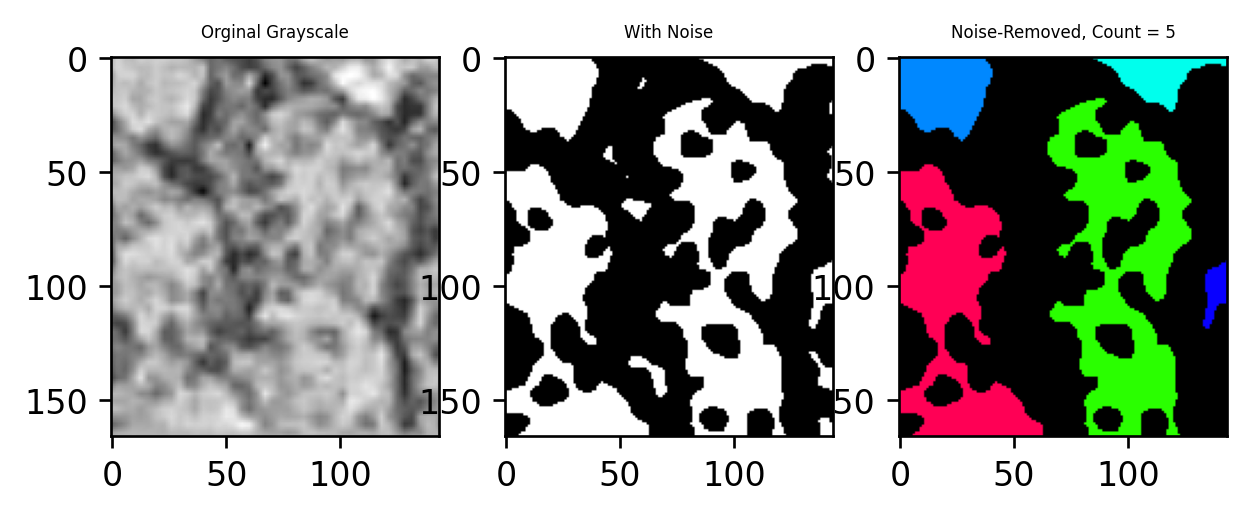

Blocksize, iterations: 15, 1
Finished on first try.


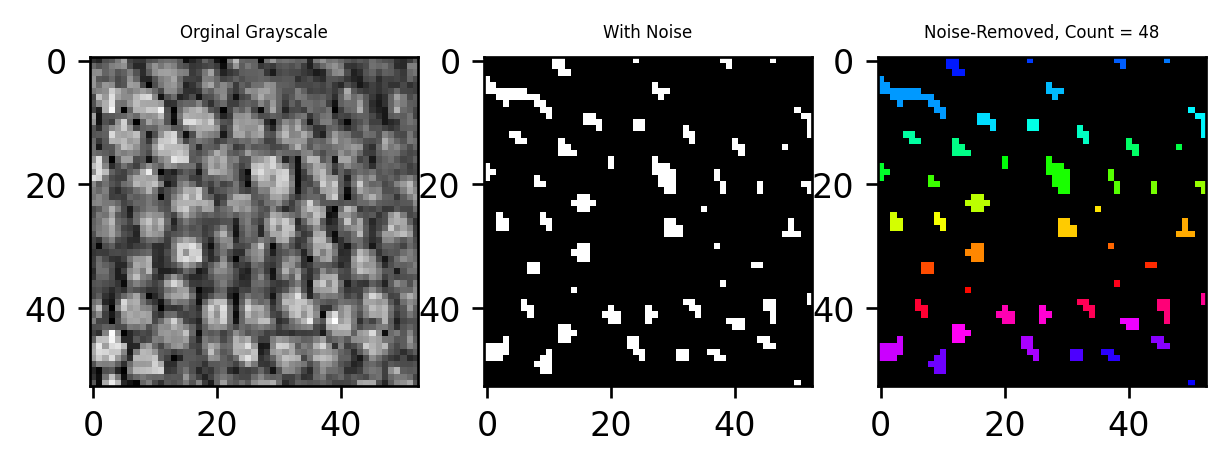

Blocksize, iterations: 15, 1
Finished on first try.


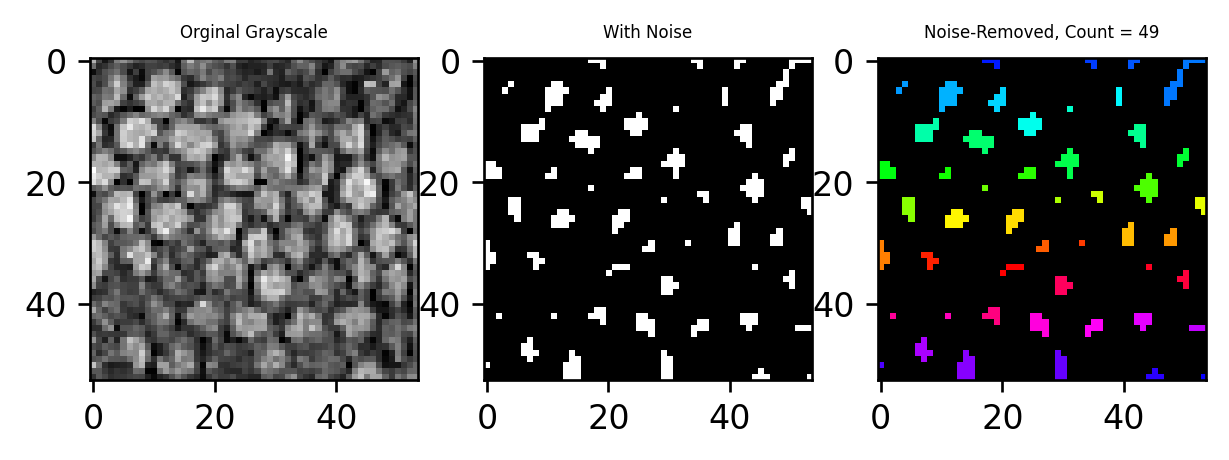

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


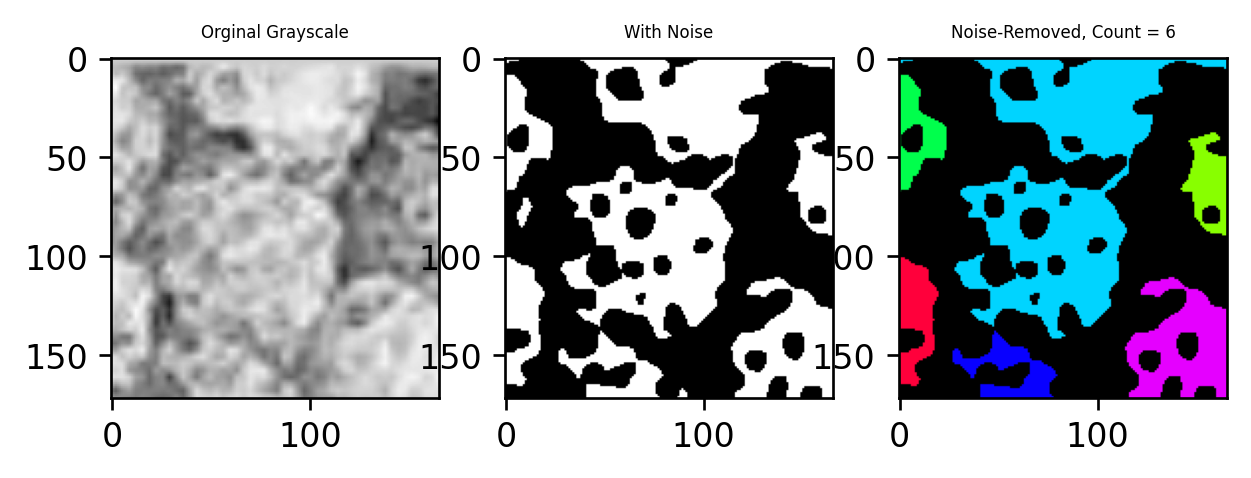

Blocksize, iterations: 15, 1
Finished on first try.


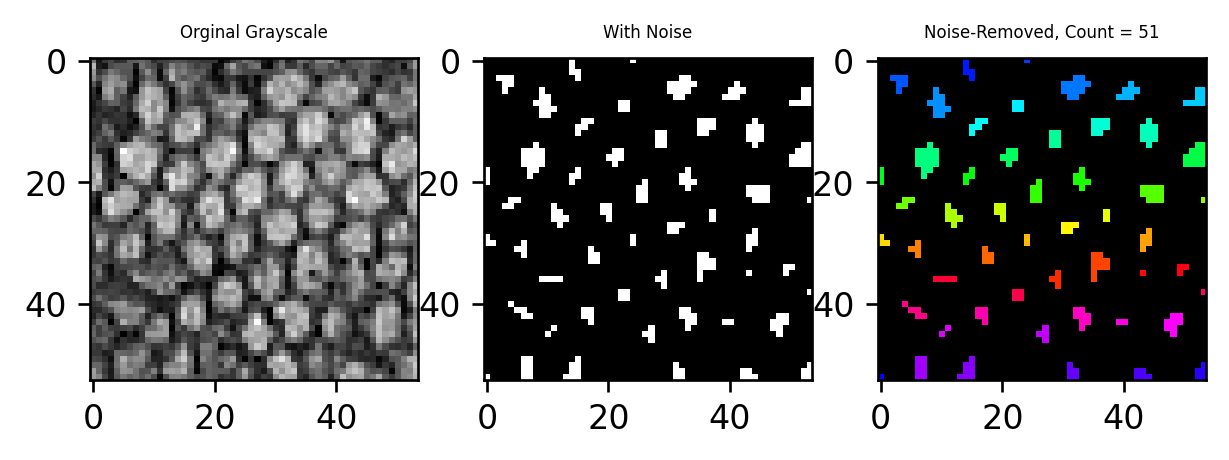

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


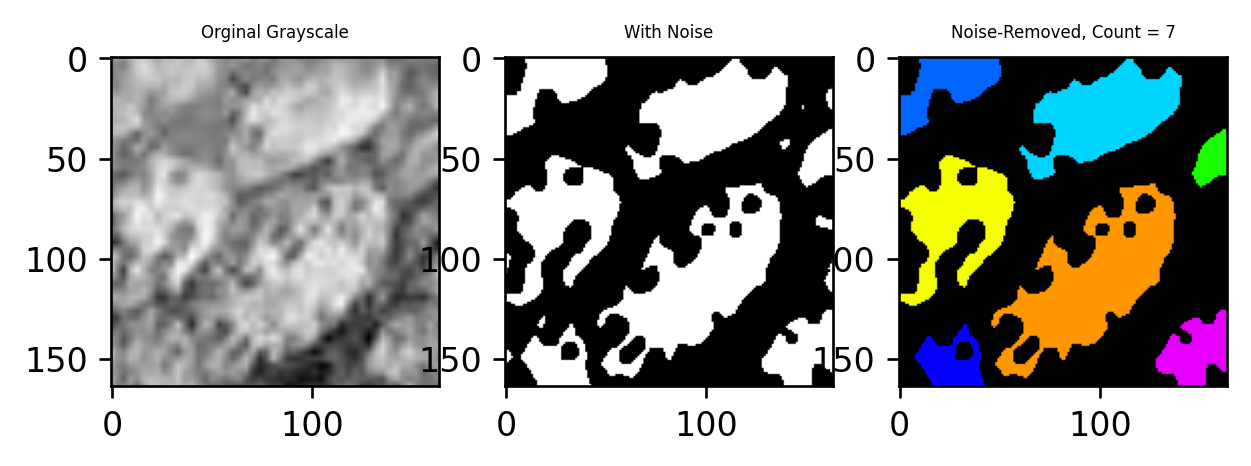

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


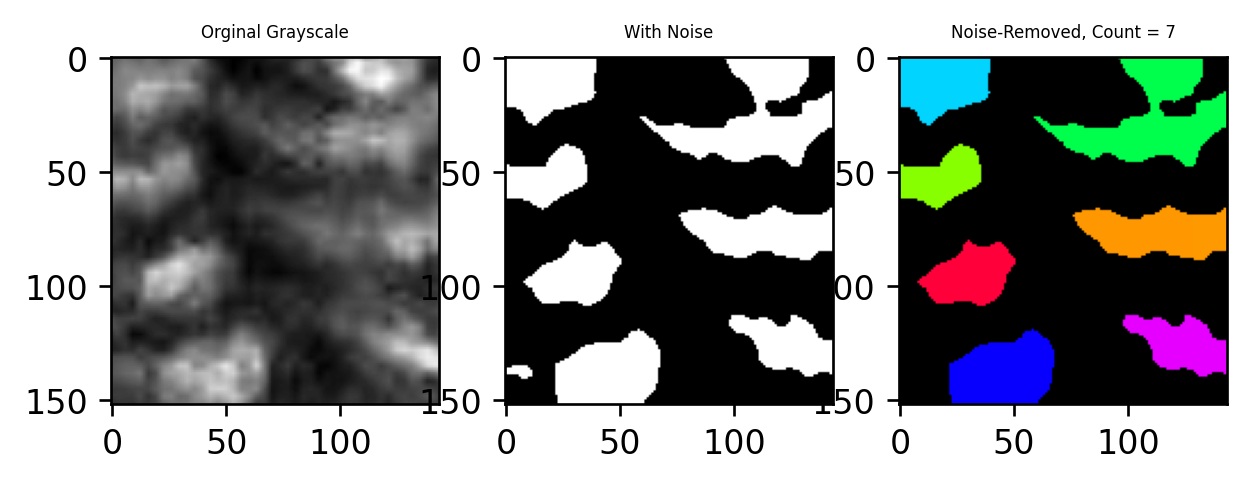

Blocksize, iterations: 15, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


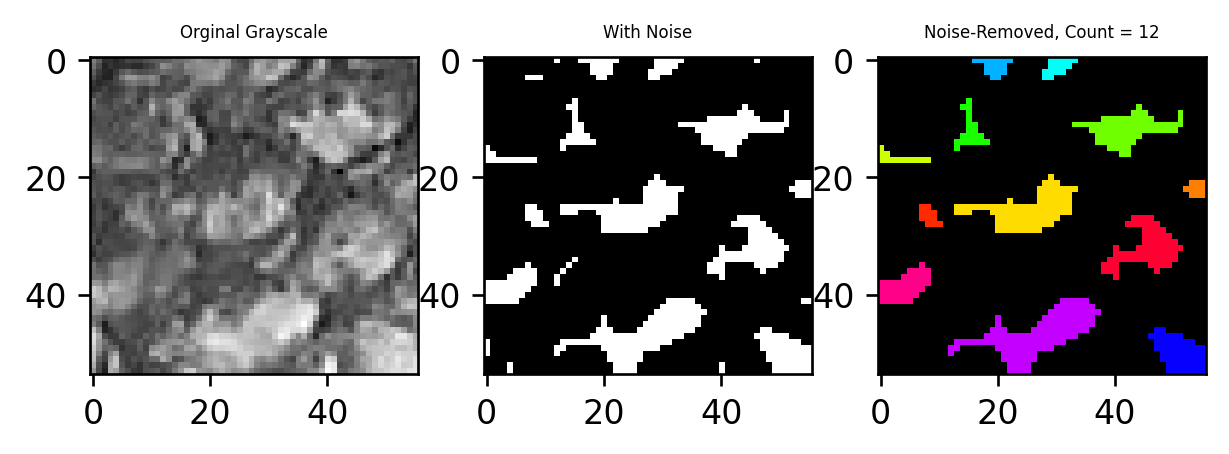

Blocksize, iterations: 65, 3
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


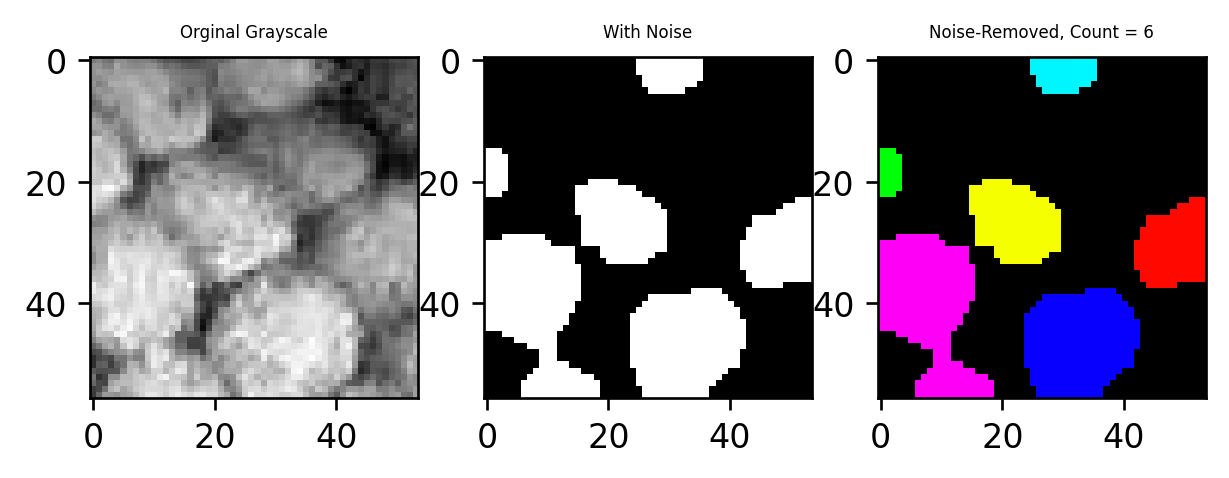

Blocksize, iterations: 85, 1
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


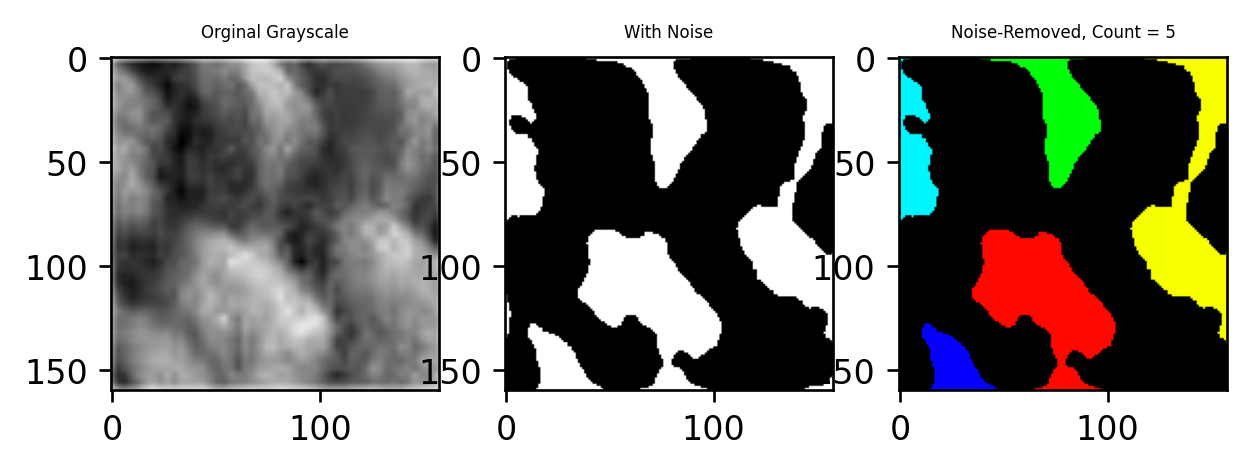

Blocksize, iterations: 65, 2
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


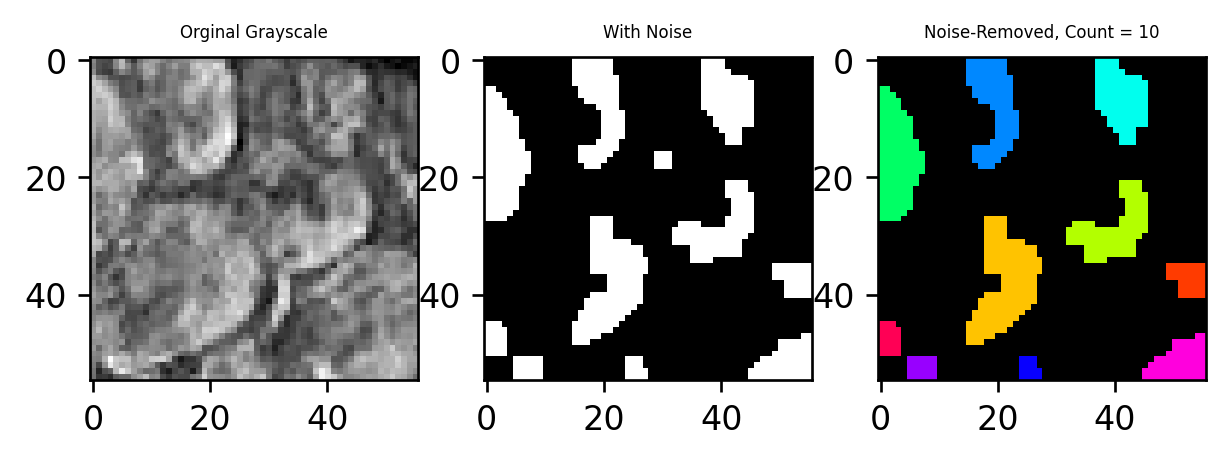

Blocksize, iterations: 65, 3
Blocksize, iterations: 85, 1
Tried both original and inverted, but original was better.


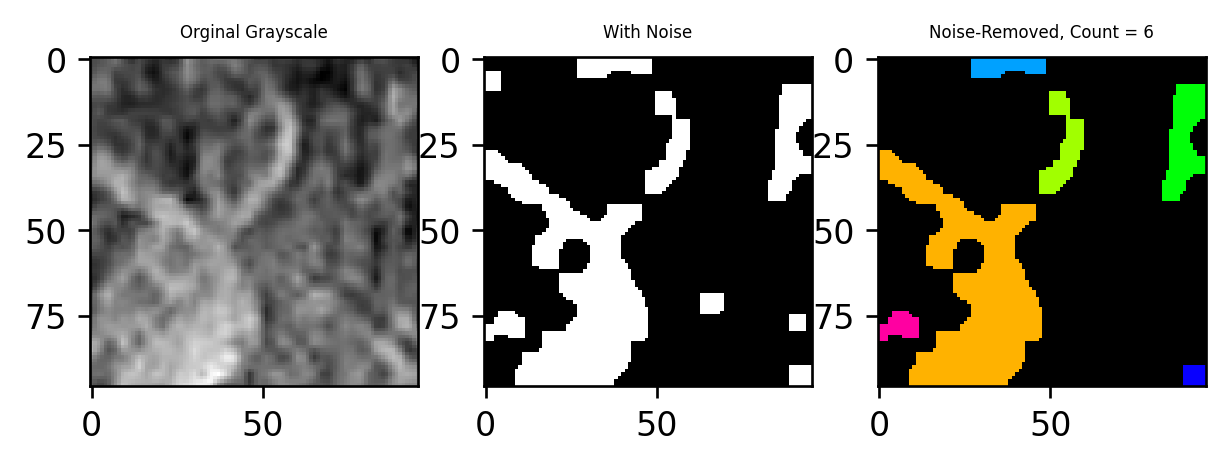

Blocksize, iterations: 85, 1
Blocksize, iterations: 65, 3
Decided to used inverted image.


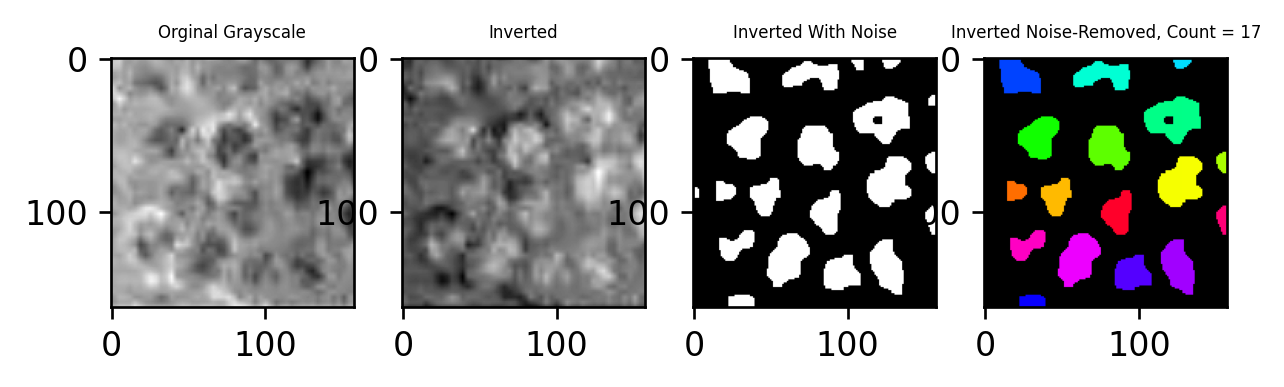

Blocksize, iterations: 65, 2
Blocksize, iterations: 15, 1
Tried both original and inverted, but original was better.


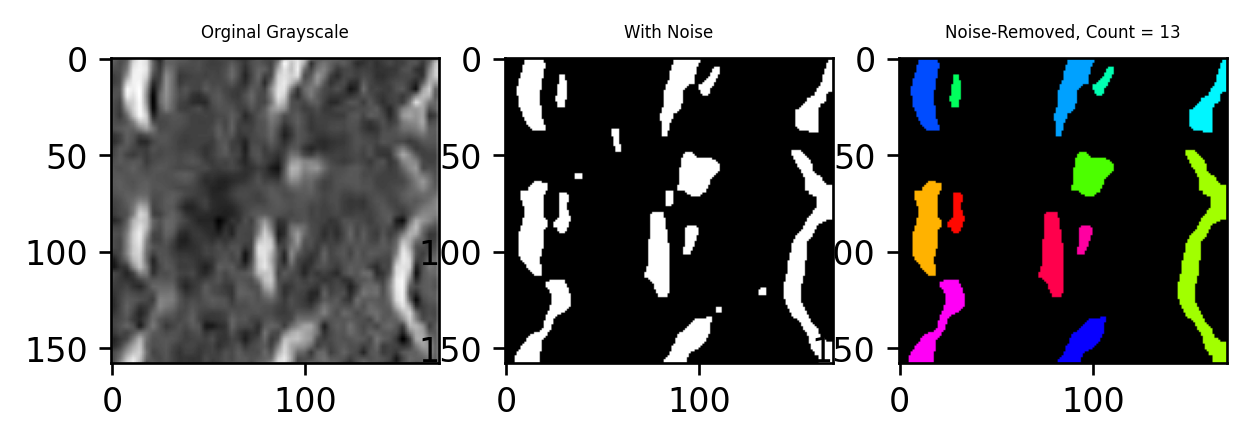

Blocksize, iterations: 85, 1
Blocksize, iterations: 65, 2
Tried both original and inverted, but original was better.


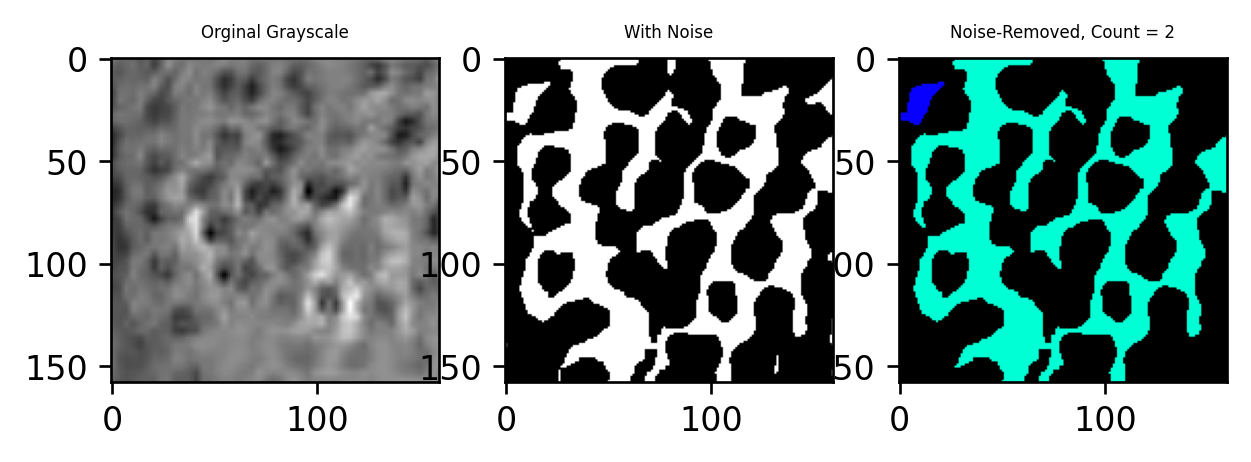

In [309]:
dirname = 'Anolis_cristatellus_images/'
directory = os.scandir(dirname)
for img in directory:
    if (img.name == '.ipynb_checkpoints' or img.name == '.DS_Store'): # need to figure how to remove these files
        continue
    img = cv2.imread(dirname + img.name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # count scales on original image
    with_noise, labeled_img, count = count_scales(img)
    
    # check how good the results are
    size_var, overlap, fullness, squareness = analyze_results(labeled_img)
    
    # If the result is good, display results and finish
    if (size_var and overlap and fullness and squareness and
        size_var < 1 and overlap < 0.63 and fullness > 0.7 and squareness > 0.5):
            print("Finished on first try.")
            display_results_orig(img, with_noise, labeled_img, count)
            
    # Otherwise, try inverted image and compare results to original
    else:
        # save the original results in lists for later use
        result_images = [[img, with_noise, labeled_img, count]]
        result_data = [[size_var, overlap, fullness, squareness]]
    
        # invert image
        inverted_img = invert(img)
    
        # count scales on inverted image
        with_noise, labeled_img, count = count_scales(inverted_img)
    
        # check how good the new results are
        size_var, overlap, fullness, squareness = analyze_results(labeled_img)
        result_data.append([size_var, overlap, fullness, squareness])
        
        # compare the results from original and inverted images
        best_index = compare_results(result_data)
    
        if best_index == 0:
            print("Tried both original and inverted, but original was better.")
            display_results_orig(result_images[0][0], result_images[0][1], result_images[0][2], result_images[0][3])
        else:
            print("Decided to used inverted image.")
            display_results_invert(img, inverted_img, with_noise, labeled_img, count)